The following code provides examples of Chapter 15, Advanced Deep Learning Topics. Please note that these examples are not intended to be used as-is, but rather as a reference for understanding the concepts and techniques presented in the book. These topics might be really complex, and it is not recommended to attempt to implement them without understanding the underlying concepts.
The code snippets might not be optimized for performance, and it is not recommended to use them as-is in production environments.

# 1. Transformers

Visualizing attention example...


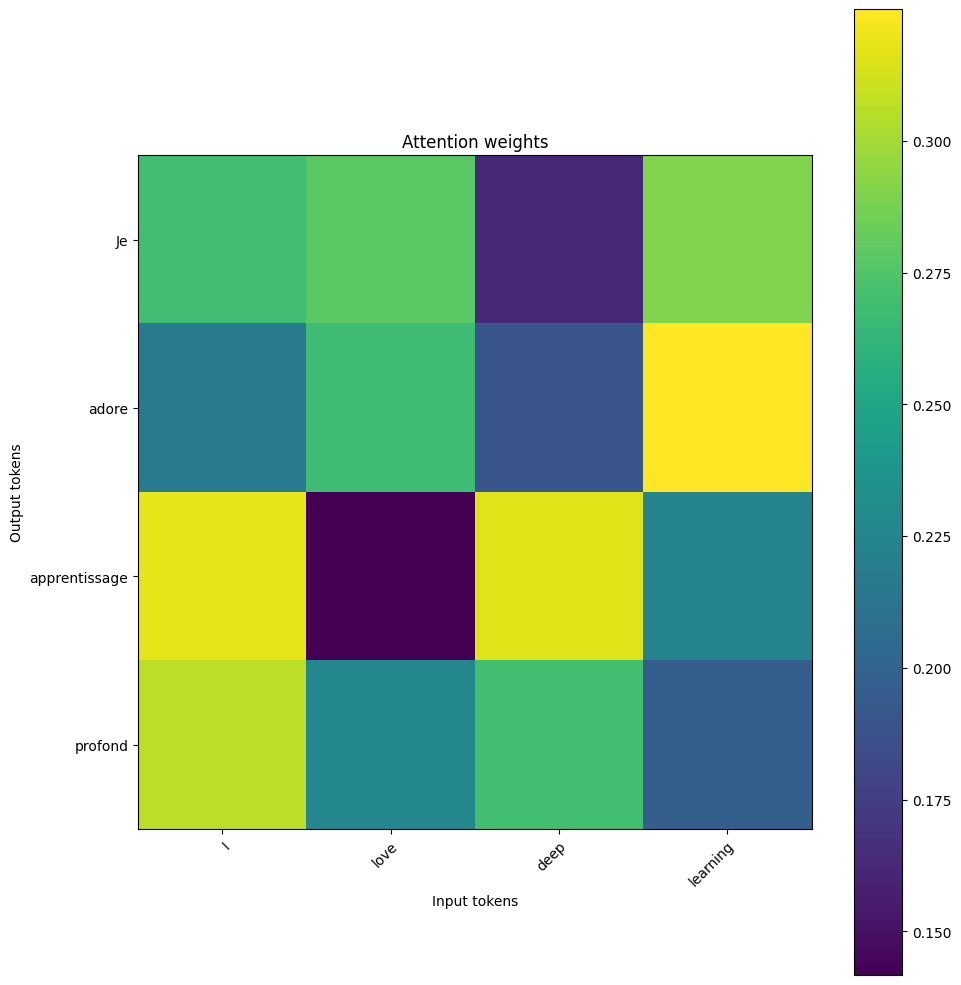


Training Transformer model...
Epoch [1/5], Batch [10/16], Loss: 0.6789, Accuracy: 47.81%
Epoch [1/5], Average Loss: 0.6993, Accuracy: 50.70%
Epoch [2/5], Batch [10/16], Loss: 0.6815, Accuracy: 53.75%
Epoch [2/5], Average Loss: 0.6908, Accuracy: 52.60%
Epoch [3/5], Batch [10/16], Loss: 0.6651, Accuracy: 55.94%
Epoch [3/5], Average Loss: 0.6863, Accuracy: 54.50%
Epoch [4/5], Batch [10/16], Loss: 0.7021, Accuracy: 53.59%
Epoch [4/5], Average Loss: 0.6873, Accuracy: 54.40%
Epoch [5/5], Batch [10/16], Loss: 0.6797, Accuracy: 54.69%
Epoch [5/5], Average Loss: 0.6819, Accuracy: 53.80%
Training completed!

Script execution completed!


In [ ]:

# Demonstrating Transformer and attention mechanisms with PyTorch
# This script implements a simplified Transformer model with multi-head attention
# and shows how it can be trained on a basic sequence-to-sequence task.

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ================================
# Part 1: Attention Mechanism
# ================================

def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Compute scaled dot-product attention
    
    Args:
        query: Query tensor of shape (batch_size, num_heads, seq_len_q, depth)
        key: Key tensor of shape (batch_size, num_heads, seq_len_k, depth)
        value: Value tensor of shape (batch_size, num_heads, seq_len_v, depth)
        mask: Optional mask tensor of shape (batch_size, 1, 1, seq_len_k)
        
    Returns:
        output: Weighted sum of values
        attention_weights: Attention weights
    """
    # Compute attention scores: matmul(Q, K.transpose)
    matmul_qk = torch.matmul(query, key.transpose(-2, -1))
    
    # Scale the attention scores
    depth = query.shape[-1]
    scaled_attention_logits = matmul_qk / math.sqrt(depth)
    
    # Apply mask if provided (used for padding or causal attention)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    # Apply softmax to get attention weights
    attention_weights = F.softmax(scaled_attention_logits, dim=-1)
    
    # Compute output as weighted sum of values
    output = torch.matmul(attention_weights, value)
    
    return output, attention_weights

# Visualize attention
def plot_attention_weights(attention_weights, input_tokens, output_tokens):
    """
    Visualize attention weights between input and output tokens
    
    Args:
        attention_weights: Attention weights tensor
        input_tokens: List of input tokens
        output_tokens: List of output tokens
    """
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(attention_weights.numpy(), cmap='viridis')
    
    # Add labels
    ax = plt.gca()
    ax.set_xticks(np.arange(len(input_tokens)))
    ax.set_yticks(np.arange(len(output_tokens)))
    ax.set_xticklabels(input_tokens)
    ax.set_yticklabels(output_tokens)
    
    plt.xlabel('Input tokens')
    plt.ylabel('Output tokens')
    plt.title('Attention weights')
    
    # Rotate the x-axis labels for better visibility
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add colorbar
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

# ================================
# Part 2: Multi-Head Attention
# ================================

class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module as described in "Attention is All You Need"
    """
    def __init__(self, d_model, num_heads):
        """
        Initialize the multi-head attention module
        
        Args:
            d_model: Model dimension
            num_heads: Number of attention heads
        """
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        # Make sure d_model is divisible by num_heads
        assert d_model % num_heads == 0
        
        self.depth = d_model // num_heads
        
        # Linear projections for Q, K, V
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        
        # Output projection
        self.dense = nn.Linear(d_model, d_model)
        
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (num_heads, depth)
        Transpose the result to (batch_size, num_heads, seq_len, depth)
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model)
            batch_size: Batch size
            
        Returns:
            Reshaped tensor of shape (batch_size, num_heads, seq_len, depth)
        """
        # Reshape x to (batch_size, seq_len, num_heads, depth)
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        
        # Transpose to (batch_size, num_heads, seq_len, depth)
        return x.permute(0, 2, 1, 3)
        
    def forward(self, query, key, value, mask=None):
        """
        Forward pass for multi-head attention
        
        Args:
            query: Query tensor of shape (batch_size, seq_len_q, d_model)
            key: Key tensor of shape (batch_size, seq_len_k, d_model)
            value: Value tensor of shape (batch_size, seq_len_v, d_model)
            mask: Optional mask tensor
            
        Returns:
            output: Multi-head attention output
            attention_weights: Attention weights
        """
        batch_size = query.shape[0]
        
        # Linear projections
        q = self.wq(query)  # (batch_size, seq_len_q, d_model)
        k = self.wk(key)    # (batch_size, seq_len_k, d_model)
        v = self.wv(value)  # (batch_size, seq_len_v, d_model)
        
        # Split heads
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # Scaled dot-product attention
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        
        # (batch_size, num_heads, seq_len_q, depth)
        
        # Transpose to (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3)
        
        # Concatenate heads
        concat_attention = scaled_attention.reshape(batch_size, -1, self.d_model)
        
        # Final linear projection
        output = self.dense(concat_attention)
        
        return output, attention_weights

# ================================
# Part 3: Positional Encoding
# ================================

def get_positional_encoding(max_seq_len, d_model):
    """
    Compute positional encoding as described in "Attention is All You Need"
    
    Args:
        max_seq_len: Maximum sequence length
        d_model: Model dimension
        
    Returns:
        Positional encoding tensor of shape (1, max_seq_len, d_model)
    """
    # Initialize positional encoding matrix
    pos_encoding = torch.zeros(max_seq_len, d_model)
    
    # Position and dimension indices
    position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    
    # Apply sine to even indices and cosine to odd indices
    pos_encoding[:, 0::2] = torch.sin(position * div_term)
    pos_encoding[:, 1::2] = torch.cos(position * div_term)
    
    # Add batch dimension
    pos_encoding = pos_encoding.unsqueeze(0)
    
    return pos_encoding

# ================================
# Part 4: Simple Transformer Encoder
# ================================

class EncoderLayer(nn.Module):
    """
    Transformer encoder layer consisting of multi-head attention and feedforward network
    """
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        """
        Initialize encoder layer
        
        Args:
            d_model: Model dimension
            num_heads: Number of attention heads
            dff: Dimension of feedforward network
            dropout_rate: Dropout rate
        """
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        
        # Feedforward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )
        
        # Layer normalization
        self.layernorm1 = nn.LayerNorm(d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(d_model, eps=1e-6)
        
        # Dropout
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        
    def forward(self, x, mask=None):
        """
        Forward pass for encoder layer
        
        Args:
            x: Input tensor
            mask: Optional mask tensor
            
        Returns:
            out: Encoder layer output
        """
        # Multi-head attention
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        
        # Add & norm (residual connection)
        out1 = self.layernorm1(x + attn_output)
        
        # Feedforward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        
        # Add & norm (residual connection)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

class Transformer(nn.Module):
    """
    Simple Transformer model for sequence classification
    """
    def __init__(self, vocab_size, d_model, num_heads, dff, 
                 max_seq_len, num_layers, num_classes, dropout_rate=0.1):
        """
        Initialize Transformer model
        
        Args:
            vocab_size: Size of vocabulary
            d_model: Model dimension
            num_heads: Number of attention heads
            dff: Dimension of feedforward network
            max_seq_len: Maximum sequence length
            num_layers: Number of encoder layers
            num_classes: Number of output classes
            dropout_rate: Dropout rate
        """
        super(Transformer, self).__init__()
        
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional encoding
        self.pos_encoding = get_positional_encoding(max_seq_len, d_model)
        
        # Encoder layers
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, dff, dropout_rate)
            for _ in range(num_layers)
        ])
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
        
        # Output layer
        self.final_layer = nn.Linear(d_model, num_classes)
        
    def forward(self, x, mask=None):
        """
        Forward pass for Transformer model
        
        Args:
            x: Input tensor of shape (batch_size, seq_len)
            mask: Optional mask tensor
            
        Returns:
            output: Model output
        """
        seq_len = x.shape[1]
        
        # Embedding
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        
        # Scale embeddings
        x = x * math.sqrt(self.d_model)
        
        # Add positional encoding
        x = x + self.pos_encoding[:, :seq_len, :].to(x.device)
        
        # Dropout
        x = self.dropout(x)
        
        # Encoder layers
        for i, enc_layer in enumerate(self.enc_layers):
            x = enc_layer(x, mask)
        
        # Global average pooling
        x = torch.mean(x, dim=1)
        
        # Final layer
        output = self.final_layer(x)
        
        return output

# ================================
# Part 5: Example Usage
# ================================

# Simple sentiment classification task using a toy dataset
class SentimentDataset(Dataset):
    """
    Toy dataset for sentiment classification
    """
    def __init__(self, num_samples=1000, max_length=20, vocab_size=1000):
        """
        Initialize dataset
        
        Args:
            num_samples: Number of samples
            max_length: Maximum sequence length
            vocab_size: Size of vocabulary
        """
        self.num_samples = num_samples
        self.max_length = max_length
        self.vocab_size = vocab_size
        
        # Generate random data
        self.data = []
        for _ in range(num_samples):
            # Random sequence length between 5 and max_length
            length = np.random.randint(5, max_length + 1)
            
            # Random sequence of token ids
            sequence = np.random.randint(1, vocab_size, size=length)
            
            # Random label (0: negative, 1: positive)
            label = np.random.randint(0, 2)
            
            self.data.append((sequence, label))
            
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        """
        Get a sample
        
        Args:
            idx: Index
            
        Returns:
            sequence: Padded sequence
            label: Label
        """
        sequence, label = self.data[idx]
        
        # Pad sequence to max_length
        padded_sequence = np.zeros(self.max_length, dtype=np.int64)
        padded_sequence[:len(sequence)] = sequence
        
        return torch.tensor(padded_sequence), torch.tensor(label)

def train_transformer():
    """
    Train a Transformer model for sentiment classification
    """
    # Hyperparameters
    vocab_size = 1000
    d_model = 128
    num_heads = 8
    dff = 512
    max_seq_len = 20
    num_layers = 2
    num_classes = 2
    dropout_rate = 0.1
    batch_size = 64
    num_epochs = 5
    learning_rate = 1e-4
    
    # Create dataset and dataloader
    dataset = SentimentDataset(num_samples=1000, max_length=max_seq_len, vocab_size=vocab_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Create model
    model = Transformer(
        vocab_size=vocab_size,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        max_seq_len=max_seq_len,
        num_layers=num_layers,
        num_classes=num_classes,
        dropout_rate=dropout_rate
    )
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (sequences, labels) in enumerate(dataloader):
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            total_loss += loss.item()
            
            if (batch_idx + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], '
                      f'Loss: {loss.item():.4f}, Accuracy: {100 * correct/total:.2f}%')
        
        avg_loss = total_loss / len(dataloader)
        accuracy = 100 * correct / total
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, '
              f'Accuracy: {accuracy:.2f}%')
    
    print('Training completed!')
    return model

# Example of attention visualization
def visualize_attention_example():
    """
    Visualize attention between a pair of sentences
    """
    # Define input and output tokens
    input_tokens = ['I', 'love', 'deep', 'learning']
    output_tokens = ['Je', 'adore', 'apprentissage', 'profond']
    
    # Create random attention weights
    attention_weights = torch.rand(len(output_tokens), len(input_tokens))
    attention_weights = F.softmax(attention_weights, dim=-1)
    
    # Plot attention weights
    plot_attention_weights(attention_weights, input_tokens, output_tokens)

# Main execution
if __name__ == "__main__":
    # Visualize a simple attention example
    print("Visualizing attention example...")
    visualize_attention_example()
    
    # Train a Transformer model
    print("\nTraining Transformer model...")
    model = train_transformer()
    
    print("\nScript execution completed!")

# 2. Graph Neural Networks


Running GCN example...


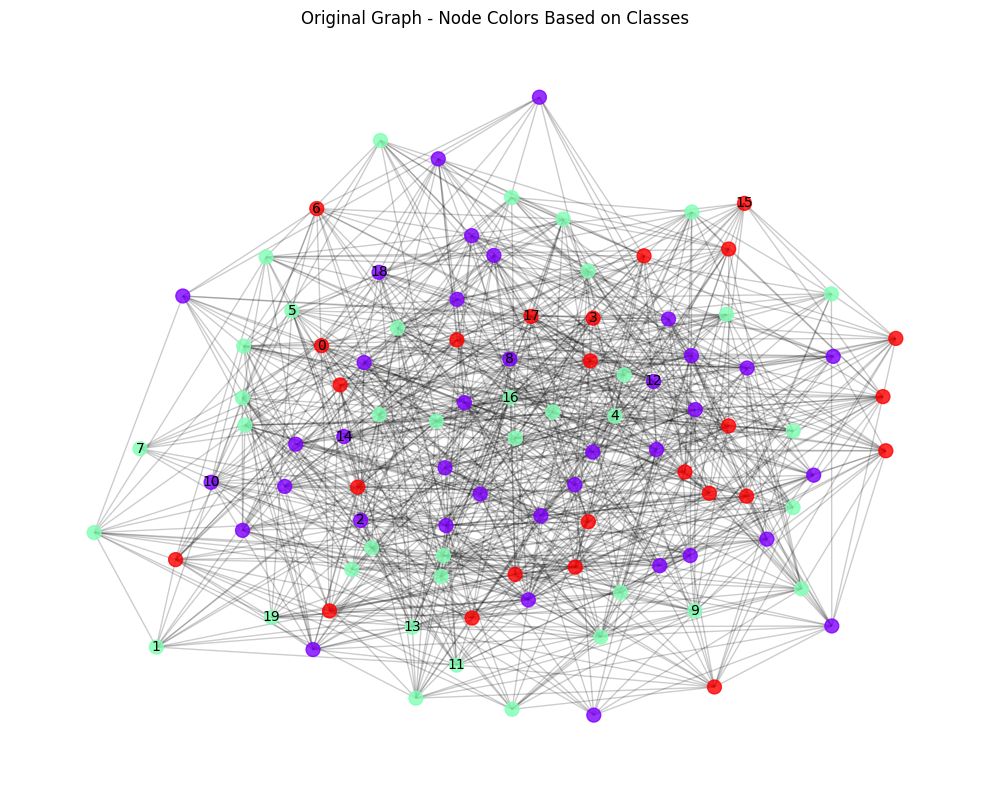

Epoch 010: Train Loss: 1.0543, Train Acc: 0.4833, Val Loss: 1.0861, Val Acc: 0.4000
Epoch 020: Train Loss: 0.9953, Train Acc: 0.5667, Val Loss: 1.0819, Val Acc: 0.4000
Epoch 030: Train Loss: 0.9173, Train Acc: 0.5667, Val Loss: 1.0826, Val Acc: 0.4000
Epoch 040: Train Loss: 0.8466, Train Acc: 0.6000, Val Loss: 1.0773, Val Acc: 0.3500
Epoch 050: Train Loss: 0.7817, Train Acc: 0.6333, Val Loss: 1.1071, Val Acc: 0.4000
Epoch 060: Train Loss: 0.7324, Train Acc: 0.6667, Val Loss: 1.1181, Val Acc: 0.4000
Epoch 070: Train Loss: 0.6892, Train Acc: 0.7333, Val Loss: 1.1649, Val Acc: 0.4000
Epoch 080: Train Loss: 0.6463, Train Acc: 0.7500, Val Loss: 1.2805, Val Acc: 0.3500
Epoch 090: Train Loss: 0.6094, Train Acc: 0.7167, Val Loss: 1.3234, Val Acc: 0.3500
Epoch 100: Train Loss: 0.5803, Train Acc: 0.7833, Val Loss: 1.3271, Val Acc: 0.4000
Test Loss: 1.4189, Test Acc: 0.4000


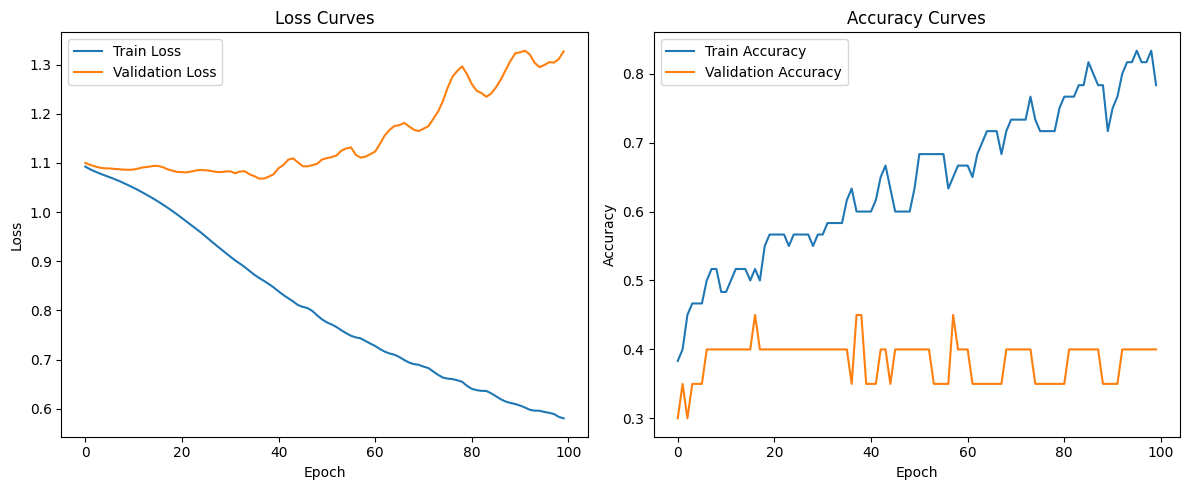

/Users/luisvalencia/Desktop/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/luisvalencia/Desktop/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/luisvalencia/Desktop/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/luisvalencia/Desktop/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/luisvalencia/Desktop/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalize

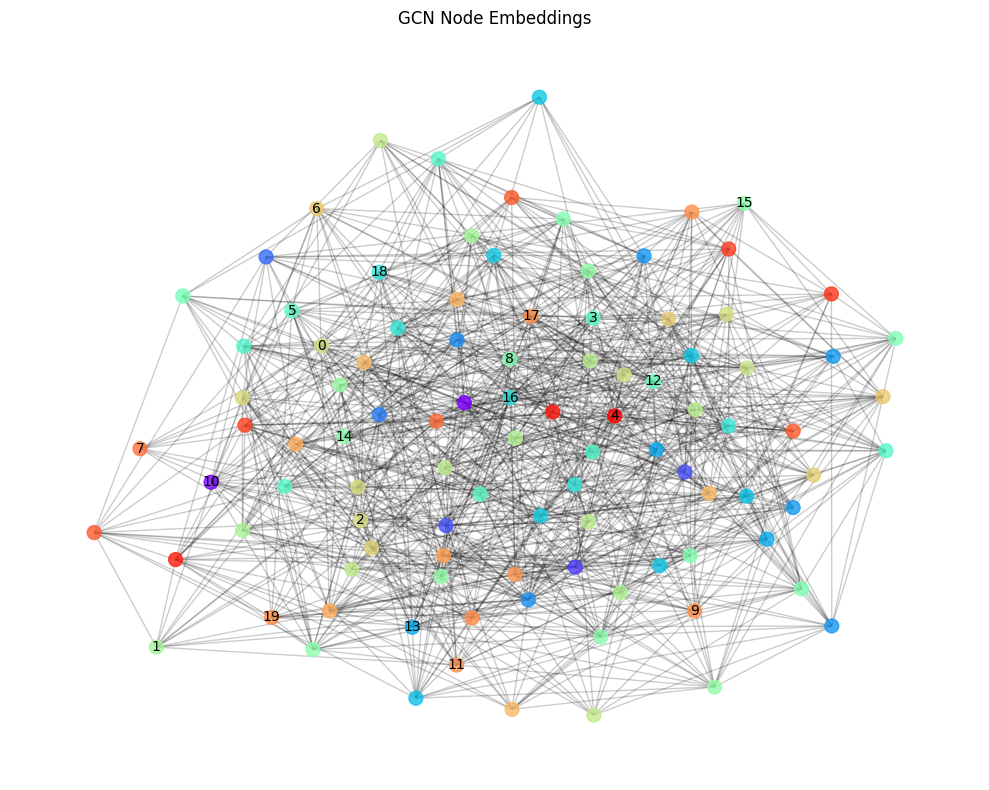

Running GAT example...
Epoch 010: Train Loss: 1.0567, Train Acc: 0.4167, Val Loss: 1.1194, Val Acc: 0.3000
Epoch 020: Train Loss: 1.0379, Train Acc: 0.4167, Val Loss: 1.1235, Val Acc: 0.3000
Epoch 030: Train Loss: 1.0201, Train Acc: 0.5333, Val Loss: 1.1115, Val Acc: 0.3000
Epoch 040: Train Loss: 1.0037, Train Acc: 0.5833, Val Loss: 1.1176, Val Acc: 0.2500
Epoch 050: Train Loss: 0.9889, Train Acc: 0.5667, Val Loss: 1.1337, Val Acc: 0.2000
Epoch 060: Train Loss: 0.9803, Train Acc: 0.5667, Val Loss: 1.1400, Val Acc: 0.2500
Epoch 070: Train Loss: 0.9670, Train Acc: 0.5833, Val Loss: 1.1539, Val Acc: 0.2500
Epoch 080: Train Loss: 0.9620, Train Acc: 0.5500, Val Loss: 1.1680, Val Acc: 0.2500
Epoch 090: Train Loss: 0.9538, Train Acc: 0.6167, Val Loss: 1.1630, Val Acc: 0.2000
Epoch 100: Train Loss: 0.9452, Train Acc: 0.5833, Val Loss: 1.1670, Val Acc: 0.2000
Test Loss: 1.1284, Test Acc: 0.5000


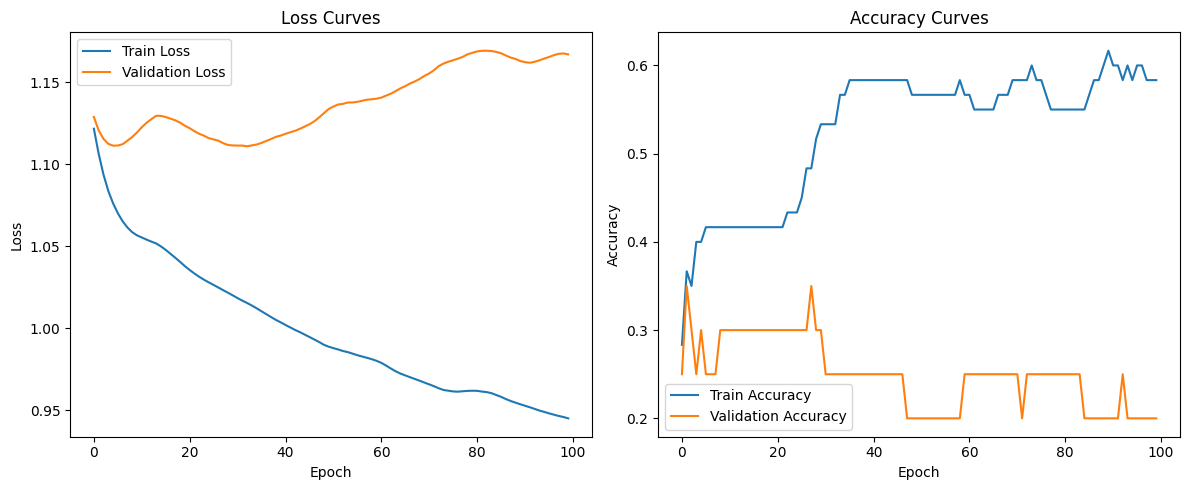

/Users/luisvalencia/Desktop/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/luisvalencia/Desktop/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/luisvalencia/Desktop/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/luisvalencia/Desktop/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/luisvalencia/Desktop/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalize

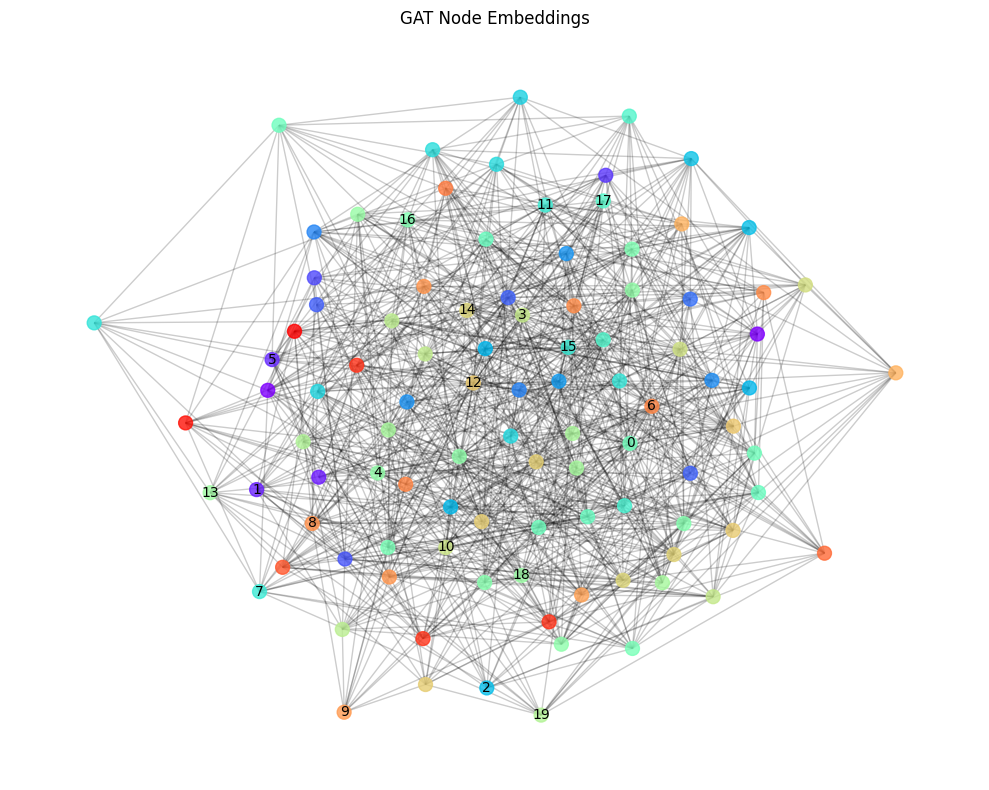


Script execution completed!


In [3]:
# Demonstrating Graph Neural Networks (GNNs) with PyTorch
# This script implements GCN and GAT models and demonstrates their application on
# a simple node classification task using a synthetic graph dataset.

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ================================
# Part 1: Graph Data Structure
# ================================

class Graph:
    """
    Simple graph data structure for GNN implementation
    """
    def __init__(self, num_nodes, feature_dim, num_classes, edge_prob=0.2):
        """
        Initialize a random graph
        
        Args:
            num_nodes: Number of nodes in the graph
            feature_dim: Dimension of node features
            num_classes: Number of node classes
            edge_prob: Probability of edge creation between nodes
        """
        self.num_nodes = num_nodes
        self.feature_dim = feature_dim
        self.num_classes = num_classes
        
        # Generate random node features
        self.node_features = torch.randn(num_nodes, feature_dim)
        
        # Generate random edges with probability edge_prob
        edge_index = []
        for i in range(num_nodes):
            for j in range(num_nodes):
                if i != j and np.random.random() < edge_prob:
                    edge_index.append([i, j])
        
        self.edge_index = torch.tensor(edge_index, dtype=torch.long).t()
        
        # Generate random node labels
        self.node_labels = torch.randint(0, num_classes, (num_nodes,))
        
        # Split indices for training, validation, and testing
        indices = torch.randperm(num_nodes)
        
        # 60% training, 20% validation, 20% testing
        train_size = int(0.6 * num_nodes)
        val_size = int(0.2 * num_nodes)
        
        self.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        self.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
        self.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        
        self.train_mask[indices[:train_size]] = True
        self.val_mask[indices[train_size:train_size+val_size]] = True
        self.test_mask[indices[train_size+val_size:]] = True
    
    def to(self, device):
        """
        Move graph to device
        
        Args:
            device: Target device
            
        Returns:
            self: Graph object
        """
        self.node_features = self.node_features.to(device)
        self.edge_index = self.edge_index.to(device)
        self.node_labels = self.node_labels.to(device)
        return self
    
    def visualize(self, node_embeds=None, title="Graph Visualization"):
        """
        Visualize the graph using NetworkX
        
        Args:
            node_embeds: Optional node embeddings for coloring
            title: Plot title
        """
        # Create a NetworkX graph
        G = nx.Graph()
        
        # Add nodes
        for i in range(self.num_nodes):
            G.add_node(i)
        
        # Add edges
        edges = self.edge_index.t().numpy()
        for i in range(edges.shape[0]):
            G.add_edge(edges[i, 0], edges[i, 1])
        
        # Calculate layout
        pos = nx.spring_layout(G, seed=42)
        
        # Plot
        plt.figure(figsize=(10, 8))
        
        # Use node labels or embeddings for colors
        if node_embeds is not None:
            # Reduce to 2D using t-SNE if embeddings have high dimensions
            if node_embeds.shape[1] > 2:
                embeddings_2d = TSNE(n_components=2).fit_transform(node_embeds.detach().cpu().numpy())
                colors = embeddings_2d[:, 0]  # Use first component for coloring
            else:
                colors = node_embeds[:, 0].detach().cpu().numpy()
        else:
            colors = self.node_labels.cpu().numpy()
        
        # Draw nodes with colors based on labels or embeddings
        nx.draw_networkx_nodes(G, pos, 
                              node_color=colors, 
                              cmap=plt.cm.rainbow, 
                              node_size=100,
                              alpha=0.8)
        
        # Draw edges
        nx.draw_networkx_edges(G, pos, alpha=0.2)
        
        # Add labels for a subset of nodes to avoid clutter
        labels = {i: str(i) for i in range(min(20, self.num_nodes))}
        nx.draw_networkx_labels(G, pos, labels, font_size=10)
        
        plt.title(title)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# ================================
# Part 2: Message Passing Layer
# ================================

class MessagePassingLayer(nn.Module):
    """
    Basic message passing layer for GNNs
    """
    def __init__(self, in_channels, out_channels):
        """
        Initialize message passing layer
        
        Args:
            in_channels: Number of input channels
            out_channels: Number of output channels
        """
        super(MessagePassingLayer, self).__init__()
        self.linear = nn.Linear(in_channels, out_channels)
    
    def forward(self, x, edge_index):
        """
        Forward pass
        
        Args:
            x: Node features of shape (num_nodes, in_channels)
            edge_index: Edge indices of shape (2, num_edges)
            
        Returns:
            out: Updated node features
        """
        # Transform node features
        x = self.linear(x)
        
        # Initialize output with zeros
        out = torch.zeros_like(x)
        
        # Simple aggregation: sum of neighbor features
        src, dst = edge_index
        for i in range(edge_index.shape[1]):
            out[dst[i]] += x[src[i]]
        
        return out

# ================================
# Part 3: Graph Convolutional Network (GCN)
# ================================

class GCNLayer(nn.Module):
    """
    Graph Convolutional Network layer as proposed by Kipf & Welling
    """
    def __init__(self, in_channels, out_channels):
        """
        Initialize GCN layer
        
        Args:
            in_channels: Number of input channels
            out_channels: Number of output channels
        """
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_channels, out_channels)
    
    def forward(self, x, edge_index):
        """
        Forward pass
        
        Args:
            x: Node features of shape (num_nodes, in_channels)
            edge_index: Edge indices of shape (2, num_edges)
            
        Returns:
            x: Updated node features
        """
        num_nodes = x.size(0)
        
        # Add self-loops to edge_index
        self_loops = torch.arange(num_nodes, device=edge_index.device)
        self_loops = torch.stack([self_loops, self_loops], dim=0)
        edge_index = torch.cat([edge_index, self_loops], dim=1)
        
        # Compute normalization
        src, dst = edge_index
        
        # Count number of neighbors for each node (including self)
        deg = torch.zeros(num_nodes, device=edge_index.device)
        deg = deg.scatter_add(0, dst, torch.ones_like(dst, dtype=torch.float))
        
        # Compute D^(-1/2)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        
        # Compute normalization: D^(-1/2) * A * D^(-1/2)
        norm = deg_inv_sqrt[src] * deg_inv_sqrt[dst]
        
        # Linear transformation
        x = self.linear(x)
        
        # Aggregation with normalization
        out = torch.zeros_like(x)
        for i in range(edge_index.shape[1]):
            out[dst[i]] += norm[i] * x[src[i]]
        
        return out

class GCN(nn.Module):
    """
    Graph Convolutional Network model
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        """
        Initialize GCN model
        
        Args:
            in_channels: Number of input channels
            hidden_channels: Number of hidden channels
            out_channels: Number of output channels
            dropout: Dropout probability
        """
        super(GCN, self).__init__()
        
        self.conv1 = GCNLayer(in_channels, hidden_channels)
        self.conv2 = GCNLayer(hidden_channels, out_channels)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index):
        """
        Forward pass
        
        Args:
            x: Node features
            edge_index: Edge indices
            
        Returns:
            x: Node classification probabilities
        """
        # First GCN layer with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)
        
        # Log softmax for node classification
        return F.log_softmax(x, dim=1)
    
    def get_embeddings(self, x, edge_index):
        """
        Get node embeddings from the first GCN layer
        
        Args:
            x: Node features
            edge_index: Edge indices
            
        Returns:
            embeddings: Node embeddings
        """
        # First GCN layer with ReLU activation
        embeddings = self.conv1(x, edge_index)
        embeddings = F.relu(embeddings)
        
        return embeddings

# ================================
# Part 4: Graph Attention Network (GAT)
# ================================

class GATLayer(nn.Module):
    """
    Graph Attention Network layer as proposed by Veličković et al.
    """
    def __init__(self, in_channels, out_channels, heads=1, dropout=0.6, concat=True):
        """
        Initialize GAT layer
        
        Args:
            in_channels: Number of input channels
            out_channels: Number of output channels
            heads: Number of attention heads
            dropout: Dropout probability
            concat: Whether to concatenate or average multi-head attention outputs
        """
        super(GATLayer, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.dropout = dropout
        
        # Linear transformation for node features
        self.linear = nn.Linear(in_channels, heads * out_channels, bias=False)
        
        # Attention parameters
        self.att_src = nn.Parameter(torch.empty(1, heads, out_channels))
        self.att_dst = nn.Parameter(torch.empty(1, heads, out_channels))
        
        # Initialization
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.xavier_uniform_(self.att_src)
        nn.init.xavier_uniform_(self.att_dst)
        
        # Dropout
        self.attn_dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index):
        """
        Forward pass
        
        Args:
            x: Node features of shape (num_nodes, in_channels)
            edge_index: Edge indices of shape (2, num_edges)
            
        Returns:
            out: Updated node features
        """
        num_nodes = x.size(0)
        
        # Add self-loops to edge_index
        self_loops = torch.arange(num_nodes, device=edge_index.device)
        self_loops = torch.stack([self_loops, self_loops], dim=0)
        edge_index = torch.cat([edge_index, self_loops], dim=1)
        
        # Linear transformation and reshape for multi-head attention
        h = self.linear(x).view(num_nodes, self.heads, self.out_channels)
        
        # Source and destination nodes
        src, dst = edge_index
        
        # Compute attention coefficients
        # Shape: (num_edges, heads)
        alpha_src = (h[src] * self.att_src).sum(dim=-1)
        alpha_dst = (h[dst] * self.att_dst).sum(dim=-1)
        alpha = alpha_src + alpha_dst
         # Compute attention coefficients
        # Shape: (num_edges, heads)
        alpha_src = (h[src] * self.att_src).sum(dim=-1)
        alpha_dst = (h[dst] * self.att_dst).sum(dim=-1)
        alpha = alpha_src + alpha_dst
        
        # Apply LeakyReLU activation
        alpha = F.leaky_relu(alpha, negative_slope=0.2)
        
        # Compute softmax along neighboring nodes
        # First, create an index to group edges by destination node
        alpha_by_dst = {}
        for i in range(len(dst)):
            node = dst[i].item()
            if node not in alpha_by_dst:
                alpha_by_dst[node] = []
            alpha_by_dst[node].append(i)
        
        # Apply softmax to each group
        attention = torch.zeros_like(alpha)
        for node, indices in alpha_by_dst.items():
            attention[indices] = F.softmax(alpha[indices], dim=0)
        
        # Apply dropout to attention coefficients
        attention = self.attn_dropout(attention)
        
        # Initialize output with zeros
        if self.concat:
            out = torch.zeros(num_nodes, self.heads * self.out_channels, device=x.device)
        else:
            out = torch.zeros(num_nodes, self.out_channels, device=x.device)
        
        # Weighted aggregation of neighbor features
        for i in range(edge_index.shape[1]):
            if self.concat:
                # Reshape for concatenation
                out[dst[i]] += (attention[i].view(-1, 1) * h[src[i]]).view(-1)
            else:
                # Average over heads
                out[dst[i]] += torch.mean(attention[i].view(-1, 1) * h[src[i]], dim=0)
        
        return out

class GAT(nn.Module):
    """
    Graph Attention Network model
    """
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        """
        Initialize GAT model
        
        Args:
            in_channels: Number of input channels
            hidden_channels: Number of hidden channels
            out_channels: Number of output channels
            heads: Number of attention heads
            dropout: Dropout probability
        """
        super(GAT, self).__init__()
        
        # First GAT layer with multi-head attention
        self.conv1 = GATLayer(in_channels, hidden_channels, heads=heads, 
                            dropout=dropout, concat=True)
        
        # Second GAT layer with single-head attention
        self.conv2 = GATLayer(hidden_channels * heads, out_channels, heads=1, 
                            dropout=dropout, concat=False)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index):
        """
        Forward pass
        
        Args:
            x: Node features
            edge_index: Edge indices
            
        Returns:
            x: Node classification probabilities
        """
        # First GAT layer with ELU activation
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)
        
        # Second GAT layer
        x = self.conv2(x, edge_index)
        
        # Log softmax for node classification
        return F.log_softmax(x, dim=1)
    
    def get_embeddings(self, x, edge_index):
        """
        Get node embeddings from the first GAT layer
        
        Args:
            x: Node features
            edge_index: Edge indices
            
        Returns:
            embeddings: Node embeddings
        """
        # First GAT layer with ELU activation
        embeddings = self.conv1(x, edge_index)
        embeddings = F.elu(embeddings)
        
        return embeddings

# ================================
# Part 5: Training Functions
# ================================

def train_model(model, graph, optimizer, epochs=100):
    """
    Train a GNN model
    
    Args:
        model: GNN model
        graph: Graph data
        optimizer: Optimizer
        epochs: Number of epochs
        
    Returns:
        model: Trained model
        history: Training history
    """
    model.train()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        # Forward pass
        optimizer.zero_grad()
        out = model(graph.node_features, graph.edge_index)
        
        # Compute loss on training nodes
        loss = F.nll_loss(out[graph.train_mask], graph.node_labels[graph.train_mask])
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            out = model(graph.node_features, graph.edge_index)
            
            # Training metrics
            train_loss = F.nll_loss(out[graph.train_mask], graph.node_labels[graph.train_mask]).item()
            train_acc = accuracy(out[graph.train_mask], graph.node_labels[graph.train_mask])
            
            # Validation metrics
            val_loss = F.nll_loss(out[graph.val_mask], graph.node_labels[graph.val_mask]).item()
            val_acc = accuracy(out[graph.val_mask], graph.node_labels[graph.val_mask])
            
            # Save metrics
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:03d}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        model.train()
    
    return model, history

def test_model(model, graph):
    """
    Test a trained GNN model
    
    Args:
        model: Trained GNN model
        graph: Graph data
        
    Returns:
        test_acc: Test accuracy
    """
    model.eval()
    with torch.no_grad():
        out = model(graph.node_features, graph.edge_index)
        test_loss = F.nll_loss(out[graph.test_mask], graph.node_labels[graph.test_mask]).item()
        test_acc = accuracy(out[graph.test_mask], graph.node_labels[graph.test_mask])
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    return test_acc

def accuracy(output, labels):
    """
    Compute classification accuracy
    
    Args:
        output: Model output
        labels: Ground truth labels
        
    Returns:
        accuracy: Classification accuracy
    """
    _, pred = output.max(dim=1)
    correct = pred.eq(labels).sum().item()
    accuracy = correct / len(labels)
    return accuracy

def plot_history(history):
    """
    Plot training history
    
    Args:
        history: Training history
    """
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')
    
    plt.tight_layout()
    plt.show()

# ================================
# Part 6: Example Usage
# ================================

def run_gcn_example():
    """
    Example usage of Graph Convolutional Network
    """
    print("Running GCN example...")
    
    # Create a random graph
    graph = Graph(num_nodes=100, feature_dim=16, num_classes=3, edge_prob=0.1)
    
    # Visualize the original graph
    graph.visualize(title="Original Graph - Node Colors Based on Classes")
    
    # Create a GCN model
    model = GCN(in_channels=16, hidden_channels=32, out_channels=3, dropout=0.5)
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    # Train the model
    model, history = train_model(model, graph, optimizer, epochs=100)
    
    # Test the model
    test_model(model, graph)
    
    # Plot training history
    plot_history(history)
    
    # Visualize node embeddings
    embeddings = model.get_embeddings(graph.node_features, graph.edge_index)
    graph.visualize(node_embeds=embeddings, title="GCN Node Embeddings")
    
    return model, graph

def run_gat_example():
    """
    Example usage of Graph Attention Network
    """
    print("Running GAT example...")
    
    # Create a random graph
    graph = Graph(num_nodes=100, feature_dim=16, num_classes=3, edge_prob=0.1)
    
    # Create a GAT model
    model = GAT(in_channels=16, hidden_channels=8, out_channels=3, heads=8, dropout=0.6)
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
    
    # Train the model
    model, history = train_model(model, graph, optimizer, epochs=100)
    
    # Test the model
    test_model(model, graph)
    
    # Plot training history
    plot_history(history)
    
    # Visualize node embeddings
    embeddings = model.get_embeddings(graph.node_features, graph.edge_index)
    graph.visualize(node_embeds=embeddings, title="GAT Node Embeddings")
    
    return model, graph

# Main execution
if __name__ == "__main__":
    # Run GCN example
    gcn_model, graph = run_gcn_example()
    
    # Run GAT example
    gat_model, graph = run_gat_example()
    
    print("\nScript execution completed!")

# 3. Bayesian Neural Networks (BNNs)

Running regression example with uncertainty quantification...

1. Monte Carlo Dropout approach:
Epoch 100/1000, Loss: 20.7166
Epoch 200/1000, Loss: 22.1053
Epoch 300/1000, Loss: 14.3103
Epoch 400/1000, Loss: 20.5282
Epoch 500/1000, Loss: 14.2047
Epoch 600/1000, Loss: 25.2463
Epoch 700/1000, Loss: 18.9146
Epoch 800/1000, Loss: 14.5896
Epoch 900/1000, Loss: 16.2883
Epoch 1000/1000, Loss: 15.5465


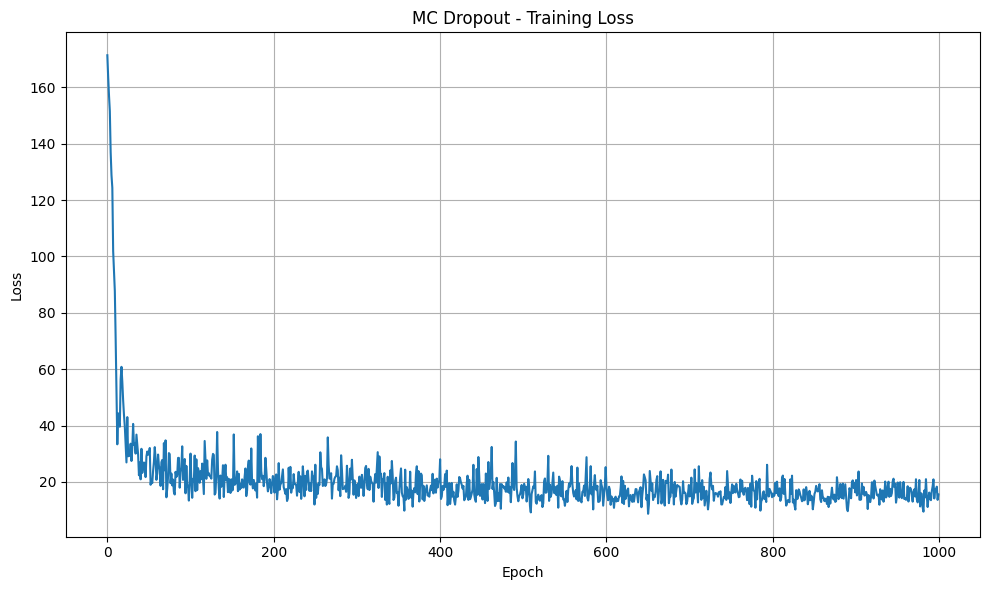

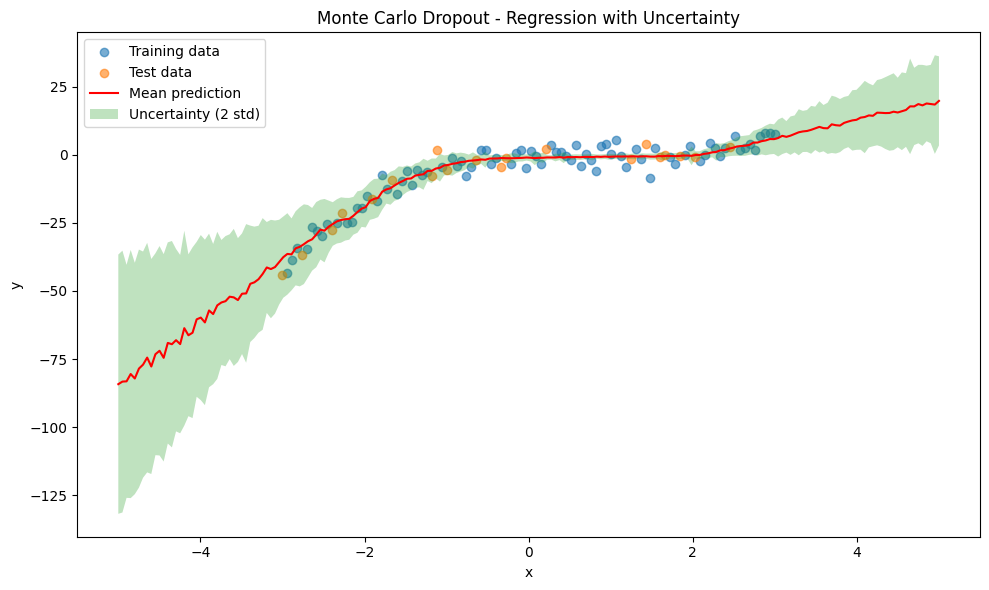


2. Variational Inference approach:
Epoch 100/1000, Loss: 131.1492, MSE: 9.6465, KL: 121.5027
Epoch 200/1000, Loss: 97.9709, MSE: 7.8356, KL: 90.1353
Epoch 300/1000, Loss: 69.5076, MSE: 8.2039, KL: 61.3036
Epoch 400/1000, Loss: 51.4773, MSE: 13.2092, KL: 38.2682
Epoch 500/1000, Loss: 32.0728, MSE: 8.0460, KL: 24.0268
Epoch 600/1000, Loss: 26.2699, MSE: 8.7640, KL: 17.5059
Epoch 700/1000, Loss: 23.3396, MSE: 9.0307, KL: 14.3089
Epoch 800/1000, Loss: 28.0502, MSE: 15.7567, KL: 12.2935
Epoch 900/1000, Loss: 18.8252, MSE: 7.8582, KL: 10.9670
Epoch 1000/1000, Loss: 19.2086, MSE: 9.0065, KL: 10.2021


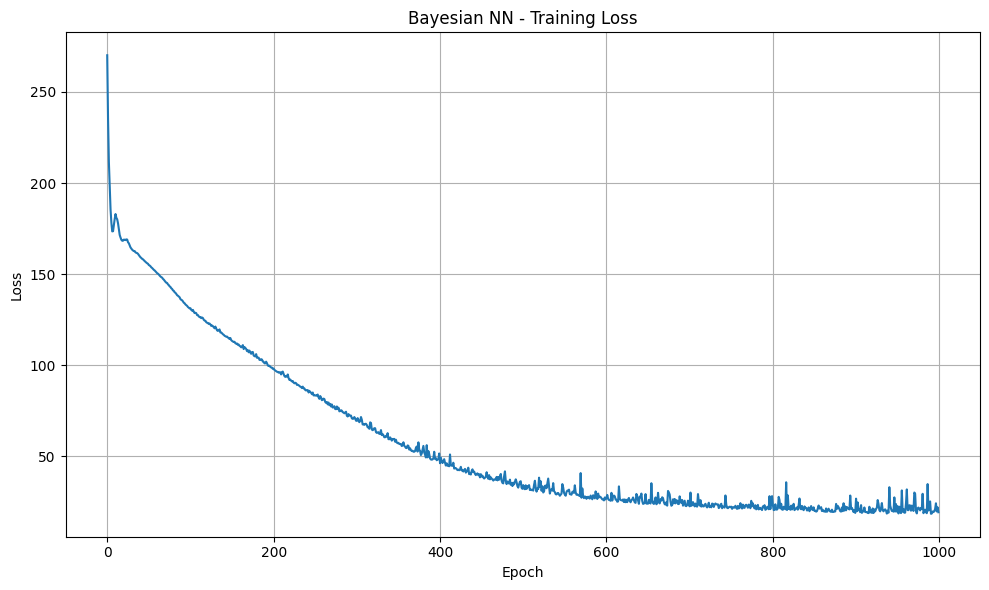

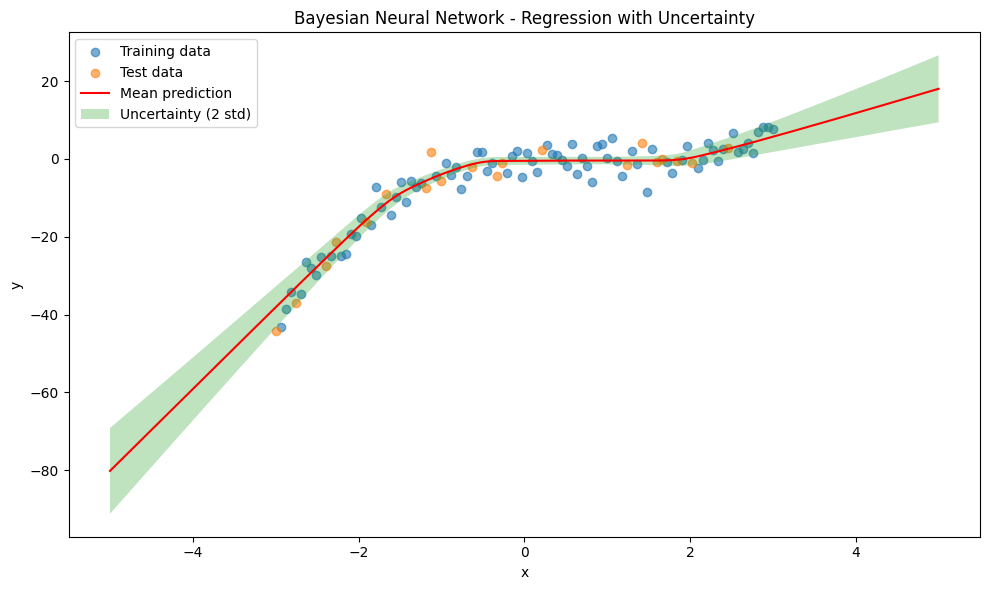

Running classification example with uncertainty quantification...

1. Monte Carlo Dropout approach:
Epoch 100/1000, Loss: 0.1339, Accuracy: 0.9500
Epoch 200/1000, Loss: 0.1135, Accuracy: 0.9625
Epoch 300/1000, Loss: 0.0741, Accuracy: 0.9625
Epoch 400/1000, Loss: 0.1023, Accuracy: 0.9583
Epoch 500/1000, Loss: 0.0771, Accuracy: 0.9583
Epoch 600/1000, Loss: 0.0664, Accuracy: 0.9750
Epoch 700/1000, Loss: 0.0503, Accuracy: 0.9750
Epoch 800/1000, Loss: 0.0602, Accuracy: 0.9625
Epoch 900/1000, Loss: 0.0941, Accuracy: 0.9625
Epoch 1000/1000, Loss: 0.0760, Accuracy: 0.9667


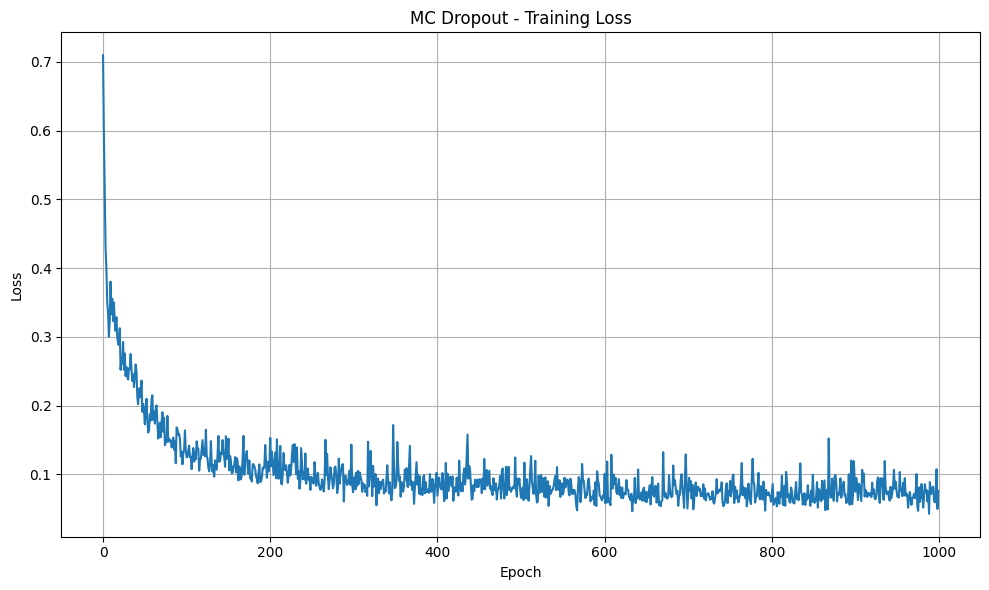

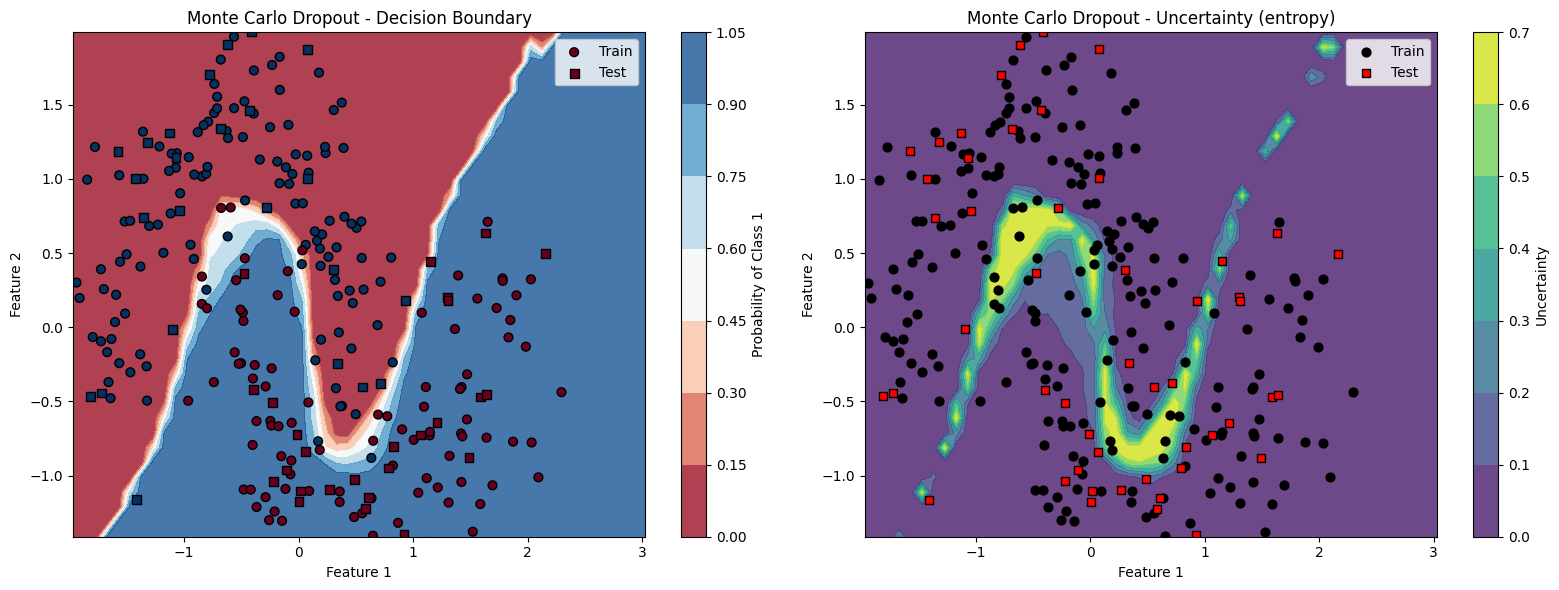


2. Variational Inference approach:
Epoch 100/1000, Loss: 41.3596, CE: 0.0792, KL: 41.2803, Accuracy: 0.9625
Epoch 200/1000, Loss: 29.8888, CE: 0.0883, KL: 29.8005, Accuracy: 0.9708
Epoch 300/1000, Loss: 19.1321, CE: 0.1628, KL: 18.9693, Accuracy: 0.9458
Epoch 400/1000, Loss: 10.0068, CE: 0.1923, KL: 9.8146, Accuracy: 0.9375
Epoch 500/1000, Loss: 5.5781, CE: 1.3891, KL: 4.1890, Accuracy: 0.5875
Epoch 600/1000, Loss: 2.2763, CE: 0.2211, KL: 2.0552, Accuracy: 0.9208
Epoch 700/1000, Loss: 1.7105, CE: 0.2428, KL: 1.4677, Accuracy: 0.9417
Epoch 800/1000, Loss: 1.4209, CE: 0.1558, KL: 1.2651, Accuracy: 0.9542
Epoch 900/1000, Loss: 1.4539, CE: 0.2668, KL: 1.1872, Accuracy: 0.9417
Epoch 1000/1000, Loss: 1.4223, CE: 0.2971, KL: 1.1252, Accuracy: 0.9333


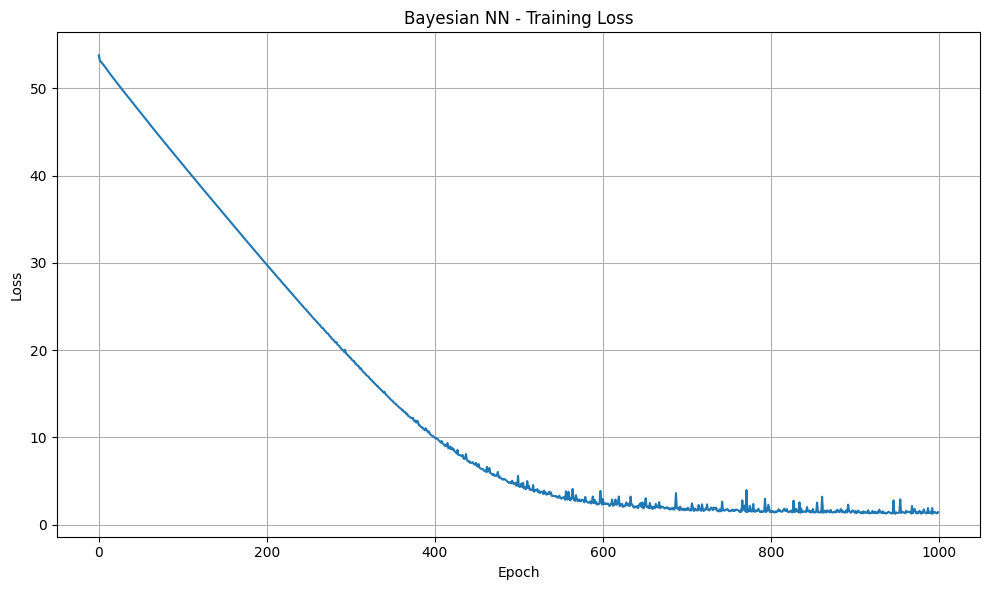

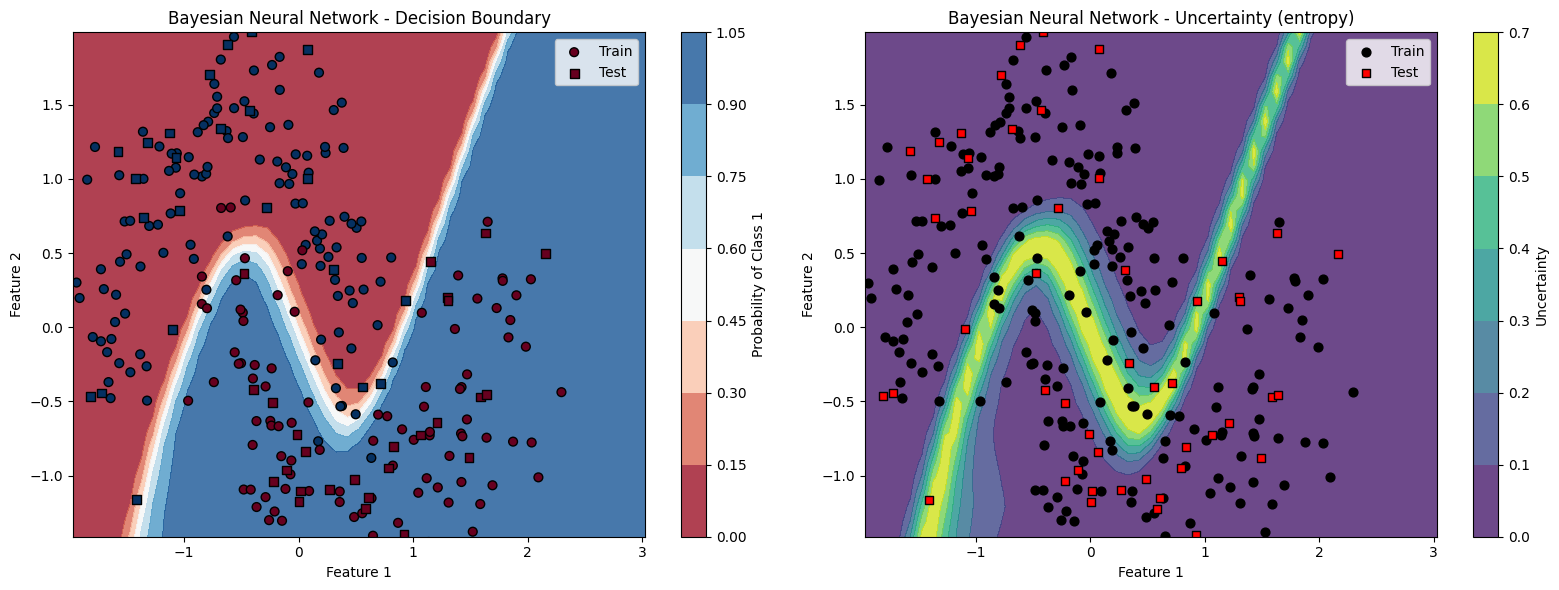


Running OOD detection example with Monte Carlo Dropout...


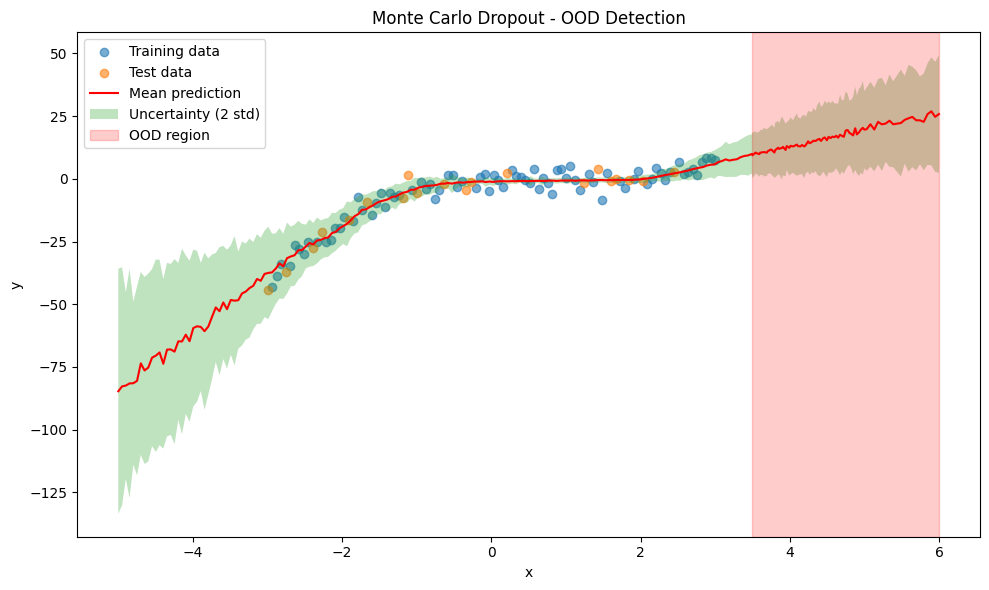

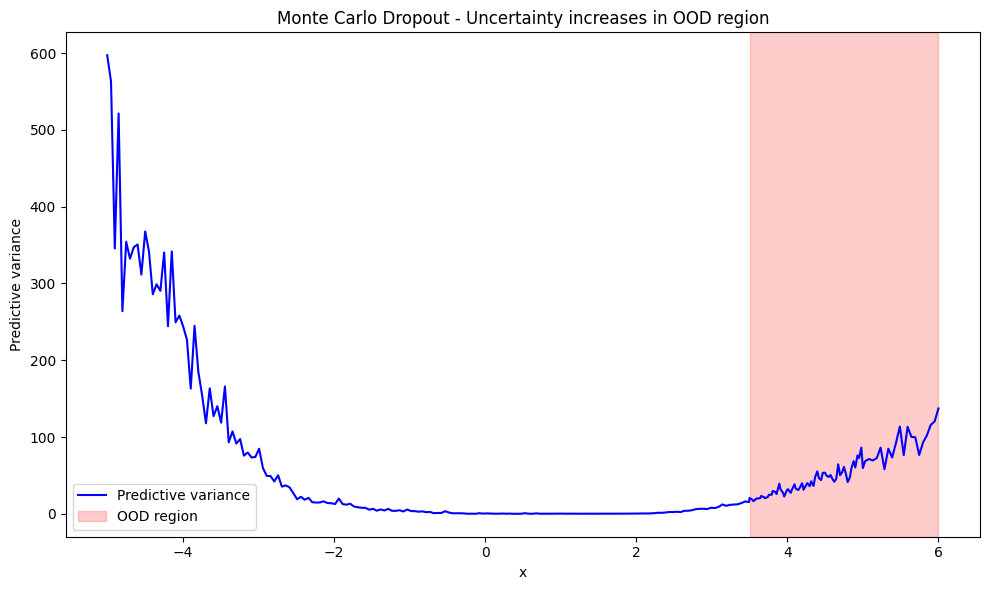


Running OOD detection example with Bayesian Neural Network...


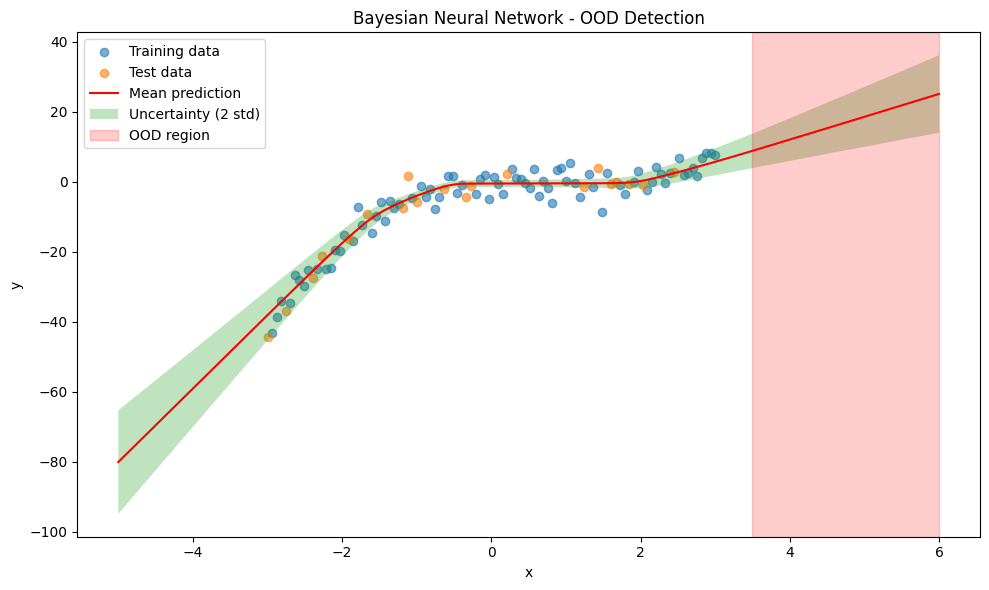

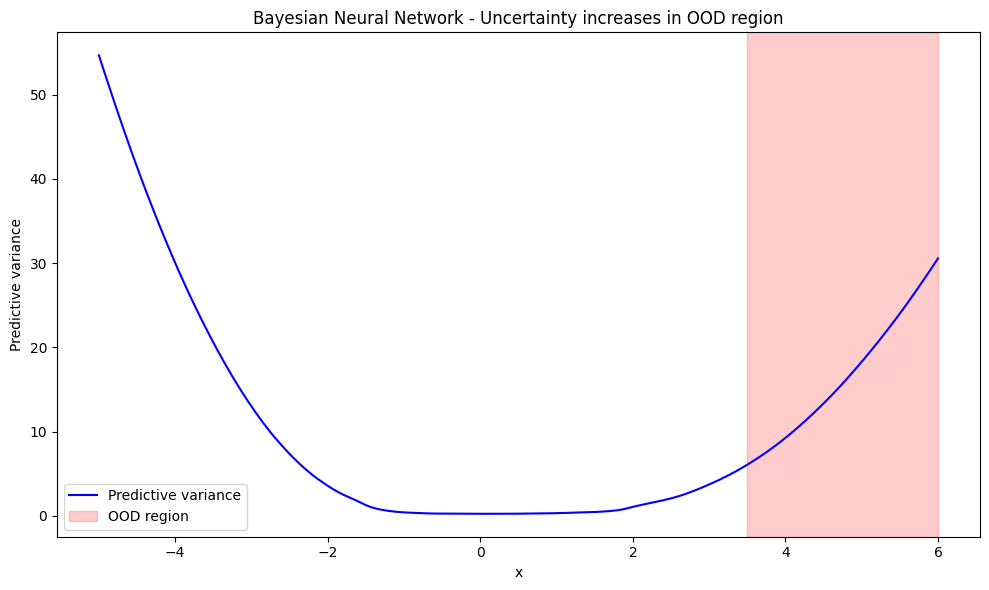


Script execution completed!


In [5]:

# Demonstrating Bayesian Neural Networks with PyTorch
# This script implements Monte Carlo Dropout and Variational Inference
# approaches to Bayesian Neural Networks and demonstrates their use for
# uncertainty quantification.

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Normal
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ================================
# Part 1: Monte Carlo Dropout
# ================================

class MCDropoutModel(nn.Module):
    """
    Neural network with Monte Carlo Dropout for uncertainty estimation
    """
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        """
        Initialize the model
        
        Args:
            input_dim: Input dimension
            hidden_dim: Hidden dimension
            output_dim: Output dimension
            dropout_rate: Dropout probability
        """
        super(MCDropoutModel, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor
            
        Returns:
            x: Output tensor
        """
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        
        return x
    
    def predict_with_uncertainty(self, x, num_samples=100):
        """
        Predict with uncertainty using Monte Carlo Dropout
        
        Args:
            x: Input tensor
            num_samples: Number of stochastic forward passes
            
        Returns:
            mean: Mean prediction
            variance: Prediction variance (uncertainty)
        """
        self.train()  # Keep dropout active during inference
        
        predictions = []
        for _ in range(num_samples):
            with torch.no_grad():
                output = self(x)
                predictions.append(output.unsqueeze(0))
        
        # Concatenate predictions along the sample dimension
        predictions = torch.cat(predictions, dim=0)
        
        # Compute mean and variance
        mean = predictions.mean(dim=0)
        variance = predictions.var(dim=0)
        
        return mean, variance

# ================================
# Part 2: Bayesian Neural Network with Variational Inference
# ================================

class BayesianLinear(nn.Module):
    """
    Bayesian Linear layer with weight and bias posteriors
    """
    def __init__(self, in_features, out_features):
        """
        Initialize Bayesian Linear layer
        
        Args:
            in_features: Input features
            out_features: Output features
        """
        super(BayesianLinear, self).__init__()
        
        # Weight mean and variance parameters
        self.weight_mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.zeros(out_features, in_features))
        
        # Bias mean and variance parameters
        self.bias_mu = nn.Parameter(torch.zeros(out_features))
        self.bias_rho = nn.Parameter(torch.zeros(out_features))
        
        # Initialize parameters
        self.reset_parameters()
        
        # Prior distribution
        # N(0, 1) for both weights and biases
        self.weight_prior = Normal(0, 1)
        self.bias_prior = Normal(0, 1)
        
        # Store KL divergence
        self.kl = 0
    
    def reset_parameters(self):
        """
        Initialize parameters
        """
        # Initialize means with Kaiming initialization
        nn.init.kaiming_normal_(self.weight_mu, mode='fan_in', nonlinearity='relu')
        
        # Initialize rho to produce small initial variances
        nn.init.constant_(self.weight_rho, -5)
        nn.init.constant_(self.bias_mu, 0)
        nn.init.constant_(self.bias_rho, -5)
    
    def forward(self, x):
        """
        Forward pass with sampled weights
        
        Args:
            x: Input tensor
            
        Returns:
            Output tensor
        """
        # Convert rho to sigma using softplus to ensure positivity
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        
        # Sample from posterior
        weight_epsilon = torch.randn_like(self.weight_mu)
        bias_epsilon = torch.randn_like(self.bias_mu)
        
        # Reparameterization trick
        weight = self.weight_mu + weight_epsilon * weight_sigma
        bias = self.bias_mu + bias_epsilon * bias_sigma
        
        # Compute KL divergence
        self.kl = self._kl_divergence(self.weight_mu, weight_sigma, self.weight_prior) + \
                  self._kl_divergence(self.bias_mu, bias_sigma, self.bias_prior)
        
        # Linear transformation
        return F.linear(x, weight, bias)
    
    def _kl_divergence(self, mu, sigma, prior):
        """
        Compute KL divergence between N(mu, sigma^2) and the prior
        
        Args:
            mu: Mean tensor
            sigma: Standard deviation tensor
            prior: Prior distribution
            
        Returns:
            kl: KL divergence
        """
        # KL[N(mu, sigma^2) || N(0, 1)]
        kl = -0.5 * torch.sum(1 + 2 * torch.log(sigma) - mu.pow(2) - sigma.pow(2))
        return kl

class BayesianNN(nn.Module):
    """
    Bayesian Neural Network with variational inference
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Initialize BNN
        
        Args:
            input_dim: Input dimension
            hidden_dim: Hidden dimension
            output_dim: Output dimension
        """
        super(BayesianNN, self).__init__()
        
        self.bfc1 = BayesianLinear(input_dim, hidden_dim)
        self.bfc2 = BayesianLinear(hidden_dim, hidden_dim)
        self.bfc3 = BayesianLinear(hidden_dim, output_dim)
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor
            
        Returns:
            x: Output tensor
        """
        x = self.bfc1(x)
        x = F.relu(x)
        
        x = self.bfc2(x)
        x = F.relu(x)
        
        x = self.bfc3(x)
        
        return x
    
    def kl_divergence(self):
        """
        Get total KL divergence of the model
        
        Returns:
            kl: KL divergence
        """
        return self.bfc1.kl + self.bfc2.kl + self.bfc3.kl
    
    def predict_with_uncertainty(self, x, num_samples=100):
        """
        Predict with uncertainty by sampling multiple times
        
        Args:
            x: Input tensor
            num_samples: Number of stochastic forward passes
            
        Returns:
            mean: Mean prediction
            variance: Prediction variance (uncertainty)
        """
        predictions = []
        for _ in range(num_samples):
            with torch.no_grad():
                output = self(x)
                predictions.append(output.unsqueeze(0))
        
        # Concatenate predictions along the sample dimension
        predictions = torch.cat(predictions, dim=0)
        
        # Compute mean and variance
        mean = predictions.mean(dim=0)
        variance = predictions.var(dim=0)
        
        return mean, variance

# ================================
# Part 3: Synthetic Example Dataset
# ================================

def generate_synthetic_data():
    """
    Generate synthetic data for regression with uncertainty
    
    Returns:
        X_train: Training inputs
        y_train: Training targets
        X_test: Test inputs
        y_test: Test targets
        X_grid: Grid points for visualization
    """
    # Generate data for a non-linear function with noise
    np.random.seed(42)
    
    # Input domain
    X = np.linspace(-3, 3, 100).reshape(-1, 1)
    
    # True function: f(x) = x^3 - 2x^2 + noise
    y = X**3 - 2 * X**2 + np.random.normal(0, 3, X.shape)
    
    # Add regions with different noise levels
    # More noise in the middle, less at the extremes
    noise_scale = 0.5 + 1.5 * np.exp(-(X - 0.5)**2/2)
    y += np.random.normal(0, noise_scale, X.shape)
    
    # Split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create a finer grid for visualization
    X_grid = np.linspace(-5, 5, 200).reshape(-1, 1)
    
    # Convert to torch tensors
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)
    X_grid = torch.FloatTensor(X_grid)
    
    return X_train, y_train, X_test, y_test, X_grid

def generate_classification_data():
    """
    Generate synthetic data for classification with uncertainty
    
    Returns:
        X_train: Training inputs
        y_train: Training labels
        X_test: Test inputs
        y_test: Test labels
        x_min, x_max, y_min, y_max: Bounds for visualization
    """
    # Generate two moons dataset
    X, y = make_moons(n_samples=300, noise=0.2, random_state=42)
    
    # Split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Create mesh grid for visualization
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    # Convert to torch tensors
    X_train = torch.FloatTensor(X_train)
    y_train = torch.LongTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.LongTensor(y_test)
    
    return X_train, y_train, X_test, y_test, x_min, x_max, y_min, y_max

# ================================
# Part 4: Training Functions
# ================================

def train_mc_dropout_regression(model, X_train, y_train, epochs=1000, lr=0.01):
    """
    Train Monte Carlo Dropout model for regression
    
    Args:
        model: MC Dropout model
        X_train: Training inputs
        y_train: Training targets
        epochs: Number of epochs
        lr: Learning rate
        
    Returns:
        model: Trained model
        losses: Training losses
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        output = model(X_train)
        loss = criterion(output, y_train)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')
    
    return model, losses

def train_bayesian_regression(model, X_train, y_train, epochs=1000, lr=0.01, samples=1):
    """
    Train Bayesian Neural Network for regression
    
    Args:
        model: BNN model
        X_train: Training inputs
        y_train: Training targets
        epochs: Number of epochs
        lr: Learning rate
        samples: Number of samples for each batch
        
    Returns:
        model: Trained model
        losses: Training losses
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Multiple forward passes for a single batch
        mse_loss = 0
        for _ in range(samples):
            output = model(X_train)
            mse_loss += criterion(output, y_train)
        
        # Average MSE loss
        mse_loss /= samples
        
        # Add KL divergence term
        kl_loss = model.kl_divergence() / len(X_train)
        loss = mse_loss + kl_loss
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, '
                  f'MSE: {mse_loss.item():.4f}, KL: {kl_loss.item():.4f}')
    
    return model, losses

def train_mc_dropout_classification(model, X_train, y_train, epochs=1000, lr=0.01):
    """
    Train Monte Carlo Dropout model for classification
    
    Args:
        model: MC Dropout model
        X_train: Training inputs
        y_train: Training labels
        epochs: Number of epochs
        lr: Learning rate
        
    Returns:
        model: Trained model
        losses: Training losses
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    losses = []
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        output = model(X_train)
        loss = criterion(output, y_train)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (epoch + 1) % 100 == 0:
            with torch.no_grad():
                pred = torch.argmax(output, dim=1)
                accuracy = (pred == y_train).float().mean().item()
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
    
    return model, losses

def train_bayesian_classification(model, X_train, y_train, epochs=1000, lr=0.01, samples=1):
    """
    Train Bayesian Neural Network for classification
    
    Args:
        model: BNN model
        X_train: Training inputs
        y_train: Training labels
        epochs: Number of epochs
        lr: Learning rate
        samples: Number of samples for each batch
        
    Returns:
        model: Trained model
        losses: Training losses
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    losses = []
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Multiple forward passes for a single batch
        ce_loss = 0
        for _ in range(samples):
            output = model(X_train)
            ce_loss += criterion(output, y_train)
        
        # Average cross entropy loss
        ce_loss /= samples
        
        # Add KL divergence term
        kl_loss = model.kl_divergence() / len(X_train)
        loss = ce_loss + kl_loss
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (epoch + 1) % 100 == 0:
            with torch.no_grad():
                pred = torch.argmax(output, dim=1)
                accuracy = (pred == y_train).float().mean().item()
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, '
                  f'CE: {ce_loss.item():.4f}, KL: {kl_loss.item():.4f}, Accuracy: {accuracy:.4f}')
    
    return model, losses

# ================================
# Part 5: Visualization Functions
# ================================

def plot_regression_uncertainty(X_train, y_train, X_test, y_test, X_grid, mean, variance, title):
    """
    Plot regression with uncertainty
    
    Args:
        X_train: Training inputs
        y_train: Training targets
        X_test: Test inputs
        y_test: Test targets
        X_grid: Grid points
        mean: Predicted mean
        variance: Predicted variance
        title: Plot title
    """
    # Convert tensors to numpy arrays
    X_train = X_train.numpy()
    y_train = y_train.numpy()
    X_test = X_test.numpy()
    y_test = y_test.numpy()
    X_grid = X_grid.numpy()
    mean = mean.numpy()
    std = np.sqrt(variance.numpy())
    
    plt.figure(figsize=(10, 6))
    
    # Plot training and test data
    plt.scatter(X_train, y_train, label='Training data', alpha=0.6)
    plt.scatter(X_test, y_test, label='Test data', alpha=0.6)
    
    # Plot mean prediction
    plt.plot(X_grid, mean, 'r-', label='Mean prediction')
    
    # Plot uncertainty
    plt.fill_between(X_grid.flatten(), mean.flatten() - 2*std.flatten(), 
                     mean.flatten() + 2*std.flatten(), alpha=0.3, 
                     label='Uncertainty (2 std)')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Continuing bayesian_neural_networks.py

def plot_classification_uncertainty(X_train, y_train, X_test, y_test, 
                                  x_min, x_max, y_min, y_max, 
                                  model, title, uncertainty_type='entropy'):
    """
    Plot classification with uncertainty
    
    Args:
        X_train: Training inputs
        y_train: Training labels
        X_test: Test inputs
        y_test: Test labels
        x_min, x_max, y_min, y_max: Bounds for visualization
        model: Model to use for prediction
        title: Plot title
        uncertainty_type: Type of uncertainty measure ('entropy' or 'variance')
    """
    # Create a mesh grid for visualization
    h = 0.1  # step size
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Convert mesh grid to torch tensor
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    
    # Predict with uncertainty
    mean, variance = model.predict_with_uncertainty(grid_tensor)
    
    # Get probabilities with softmax
    probs = F.softmax(mean, dim=1)
    
    # Get decision function (probability of class 1)
    Z = probs[:, 1].reshape(xx.shape)
    
    # Compute uncertainty
    if uncertainty_type == 'entropy':
        # Entropy of the predictive distribution
        eps = 1e-10  # to avoid log(0)
        entropy = -torch.sum(probs * torch.log(probs + eps), dim=1)
        uncertainty = entropy.reshape(xx.shape)
    else:
        # Predictive variance
        uncertainty = variance[:, 1].reshape(xx.shape)
    
    # Convert tensors to numpy arrays
    Z = Z.numpy()
    uncertainty = uncertainty.numpy()
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot decision boundary
    cs1 = ax1.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
    ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdBu_r, 
              edgecolors='k', s=40, label='Train')
    ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.RdBu_r, 
              edgecolors='k', s=40, marker='s', label='Test')
    ax1.set_xlim(xx.min(), xx.max())
    ax1.set_ylim(yy.min(), yy.max())
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax1.set_title(f'{title} - Decision Boundary')
    ax1.legend()
    
    # Plot uncertainty
    cs2 = ax2.contourf(xx, yy, uncertainty, cmap=plt.cm.viridis, alpha=0.8)
    ax2.scatter(X_train[:, 0], X_train[:, 1], c='black', 
              edgecolors='k', s=40, label='Train')
    ax2.scatter(X_test[:, 0], X_test[:, 1], c='red', 
              edgecolors='k', s=40, marker='s', label='Test')
    ax2.set_xlim(xx.min(), xx.max())
    ax2.set_ylim(yy.min(), yy.max())
    ax2.set_xlabel('Feature 1')
    ax2.set_ylabel('Feature 2')
    ax2.set_title(f'{title} - Uncertainty ({uncertainty_type})')
    ax2.legend()
    
    # Add colorbars
    plt.colorbar(cs1, ax=ax1, label='Probability of Class 1')
    plt.colorbar(cs2, ax=ax2, label='Uncertainty')
    
    plt.tight_layout()
    plt.show()

def plot_training_loss(losses, title):
    """
    Plot training loss
    
    Args:
        losses: List of training losses
        title: Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ================================
# Part 6: Example Usage
# ================================

def run_regression_example():
    """
    Run regression example with both MC Dropout and Bayesian Neural Network
    """
    print("Running regression example with uncertainty quantification...")
    
    # Generate synthetic data
    X_train, y_train, X_test, y_test, X_grid = generate_synthetic_data()
    
    # 1. Monte Carlo Dropout approach
    print("\n1. Monte Carlo Dropout approach:")
    mc_model = MCDropoutModel(input_dim=1, hidden_dim=50, output_dim=1)
    mc_model, mc_losses = train_mc_dropout_regression(mc_model, X_train, y_train)
    plot_training_loss(mc_losses, 'MC Dropout - Training Loss')
    
    # Predict with uncertainty
    mc_mean, mc_variance = mc_model.predict_with_uncertainty(X_grid)
    
    # Visualize
    plot_regression_uncertainty(X_train, y_train, X_test, y_test, 
                              X_grid, mc_mean, mc_variance, 
                              'Monte Carlo Dropout - Regression with Uncertainty')
    
    # 2. Variational Inference approach
    print("\n2. Variational Inference approach:")
    bnn_model = BayesianNN(input_dim=1, hidden_dim=50, output_dim=1)
    bnn_model, bnn_losses = train_bayesian_regression(bnn_model, X_train, y_train)
    plot_training_loss(bnn_losses, 'Bayesian NN - Training Loss')
    
    # Predict with uncertainty
    bnn_mean, bnn_variance = bnn_model.predict_with_uncertainty(X_grid)
    
    # Visualize
    plot_regression_uncertainty(X_train, y_train, X_test, y_test, 
                              X_grid, bnn_mean, bnn_variance, 
                              'Bayesian Neural Network - Regression with Uncertainty')
    
    return mc_model, bnn_model

def run_classification_example():
    """
    Run classification example with both MC Dropout and Bayesian Neural Network
    """
    print("Running classification example with uncertainty quantification...")
    
    # Generate synthetic data
    X_train, y_train, X_test, y_test, x_min, x_max, y_min, y_max = generate_classification_data()
    
    # 1. Monte Carlo Dropout approach
    print("\n1. Monte Carlo Dropout approach:")
    mc_model = MCDropoutModel(input_dim=2, hidden_dim=50, output_dim=2)
    mc_model, mc_losses = train_mc_dropout_classification(mc_model, X_train, y_train)
    plot_training_loss(mc_losses, 'MC Dropout - Training Loss')
    
    # Visualize
    plot_classification_uncertainty(X_train, y_train, X_test, y_test, 
                                  x_min, x_max, y_min, y_max, 
                                  mc_model, 'Monte Carlo Dropout', 'entropy')
    
    # 2. Variational Inference approach
    print("\n2. Variational Inference approach:")
    bnn_model = BayesianNN(input_dim=2, hidden_dim=50, output_dim=2)
    bnn_model, bnn_losses = train_bayesian_classification(bnn_model, X_train, y_train)
    plot_training_loss(bnn_losses, 'Bayesian NN - Training Loss')
    
    # Visualize
    plot_classification_uncertainty(X_train, y_train, X_test, y_test, 
                                  x_min, x_max, y_min, y_max, 
                                  bnn_model, 'Bayesian Neural Network', 'entropy')
    
    return mc_model, bnn_model

def out_of_distribution_example(model, title):
    """
    Demonstrate out-of-distribution detection with uncertainty
    
    Args:
        model: Trained model
        title: Plot title
    """
    print(f"\nRunning OOD detection example with {title}...")
    
    # Generate synthetic data
    X_train, y_train, X_test, y_test, X_grid = generate_synthetic_data()
    
    # Create out-of-distribution samples
    X_ood = torch.FloatTensor(np.linspace(3.5, 6, 50).reshape(-1, 1))
    
    # Combine in-distribution and out-of-distribution samples
    X_combined = torch.cat([X_grid, X_ood])
    
    # Sort by x value for better visualization
    sorted_indices = torch.argsort(X_combined.flatten())
    X_combined = X_combined[sorted_indices]
    
    # Predict with uncertainty
    mean, variance = model.predict_with_uncertainty(X_combined)
    
    # Visualize
    plt.figure(figsize=(10, 6))
    
    # Plot training and test data
    plt.scatter(X_train.numpy(), y_train.numpy(), label='Training data', alpha=0.6)
    plt.scatter(X_test.numpy(), y_test.numpy(), label='Test data', alpha=0.6)
    
    # Plot mean prediction
    plt.plot(X_combined.numpy(), mean.numpy(), 'r-', label='Mean prediction')
    
    # Plot uncertainty
    std = torch.sqrt(variance)
    plt.fill_between(X_combined.numpy().flatten(), 
                   (mean - 2*std).numpy().flatten(), 
                   (mean + 2*std).numpy().flatten(), 
                   alpha=0.3, label='Uncertainty (2 std)')
    
    # Highlight OOD region
    plt.axvspan(3.5, 6, alpha=0.2, color='red', label='OOD region')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'{title} - OOD Detection')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot uncertainty vs. x
    plt.figure(figsize=(10, 6))
    plt.plot(X_combined.numpy(), variance.numpy(), 'b-', label='Predictive variance')
    plt.axvspan(3.5, 6, alpha=0.2, color='red', label='OOD region')
    plt.xlabel('x')
    plt.ylabel('Predictive variance')
    plt.title(f'{title} - Uncertainty increases in OOD region')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Run regression example
    mc_model, bnn_model = run_regression_example()
    
    # Run classification example
    mc_model_cls, bnn_model_cls = run_classification_example()
    
    # Run out-of-distribution example
    out_of_distribution_example(mc_model, "Monte Carlo Dropout")
    out_of_distribution_example(bnn_model, "Bayesian Neural Network")
    
    print("\nScript execution completed!")

# 4 Neural Architecture Search

In [11]:
# Demonstrating Neural Architecture Search (NAS) concepts with PyTorch
# This script implements a simple version of differentiable architecture search (DARTS)
# and evolutionary neural architecture search.

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# ================================
# Part 1: DARTS Implementation
# ================================

class MixedOp(nn.Module):
    """
    Mixed operation that combines multiple operations with weighted sum
    """
    def __init__(self, operation_options):
        """
        Initialize mixed operation
        
        Args:
            operation_options: List of operation modules
        """
        super(MixedOp, self).__init__()
        self.ops = nn.ModuleList(operation_options)
        self.weights = nn.Parameter(torch.ones(len(operation_options)) / len(operation_options))
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor
            
        Returns:
            output: Weighted sum of operation outputs
        """
        # Apply softmax to get operation weights
        weights = F.softmax(self.weights, dim=0)
        
        # Weighted sum of operations
        return sum(w * op(x) for w, op in zip(weights, self.ops))

class DARTSCell(nn.Module):
    """
    DARTS cell with mixed operations between nodes
    """
    def __init__(self, num_nodes, channels):
        super(DARTSCell, self).__init__()
        self.num_nodes = num_nodes

        # Define possible operations
        self.operation_options = lambda in_c, out_c: [
            nn.Sequential(  # 3x3 separable conv
                nn.Conv2d(in_c, in_c, 3, padding=1, groups=in_c),
                nn.Conv2d(in_c, out_c, 1),
                nn.BatchNorm2d(out_c),
                nn.ReLU()
            ),
            nn.Sequential(  # 5x5 separable conv
                nn.Conv2d(in_c, in_c, 5, padding=2, groups=in_c),
                nn.Conv2d(in_c, out_c, 1),
                nn.BatchNorm2d(out_c),
                nn.ReLU()
            ),
            nn.Sequential(  # 3x3 dilated conv
                nn.Conv2d(in_c, out_c, 3, padding=2, dilation=2),
                nn.BatchNorm2d(out_c),
                nn.ReLU()
            ),
            nn.Sequential(  # 1x1 conv
                nn.Conv2d(in_c, out_c, 1),
                nn.BatchNorm2d(out_c),
                nn.ReLU()
            ),
            nn.Sequential(  # 3x3 max pool
                nn.MaxPool2d(3, stride=1, padding=1),
                nn.Conv2d(in_c, out_c, 1),
                nn.BatchNorm2d(out_c),
                nn.ReLU()
            ),
            nn.Sequential(  # Replace Identity with 1x1 conv to ensure consistency
                nn.Conv2d(in_c, out_c, 1),
                nn.BatchNorm2d(out_c),
                nn.ReLU()
            )
        ]

        # Create mixed operations for each edge
        self.edges = nn.ModuleDict()
        for i in range(num_nodes + 2):  # +2 for input nodes
            for j in range(i + 1, num_nodes + 2):  # Connections from earlier nodes to later ones
                # Skip connection from input to output
                if i == 0 and j == num_nodes + 1:
                    continue

                # Create mixed operation for edge (i, j)
                edge_name = f"{i}_{j}"
                self.edges[edge_name] = MixedOp(self.operation_options(channels, channels))
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor
            
        Returns:
            output: Cell output
        """
        # Nodes in the cell, each node is a feature map
        nodes = [x] * 2  # First two nodes are inputs
        
        # Process intermediate nodes
        for i in range(2, self.num_nodes + 2):
            # Collect inputs from all previous nodes
            node_inputs = []
            for j in range(i):
                edge_name = f"{j}_{i}"
                if edge_name in self.edges:
                    node_inputs.append(self.edges[edge_name](nodes[j]))
            
            # Sum the inputs for this node
            nodes.append(sum(node_inputs))
        
        # Return the last node as output
        return nodes[-1]

class DARTSModel(nn.Module):
    """
    Complete DARTS model for image classification
    """
    def __init__(self, num_classes, channels=16, num_cells=3, num_nodes=4):
        """
        Initialize DARTS model
        
        Args:
            num_classes: Number of output classes
            channels: Number of channels in the first layer
            num_cells: Number of cells
            num_nodes: Number of intermediate nodes per cell
        """
        super(DARTSModel, self).__init__()
        
        # Initial convolution
        self.stem = nn.Sequential(
            nn.Conv2d(1, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU()
        )
        
        # DARTS cells
        self.cells = nn.ModuleList([
            DARTSCell(num_nodes, channels) for _ in range(num_cells)
        ])
        
        # Global average pooling and classifier
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(channels, num_classes)
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor
            
        Returns:
            logits: Class logits
        """
        # Initial convolution
        x = self.stem(x)
        
        # Process cells
        for cell in self.cells:
            x = cell(x)
        
        # Global average pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # Classification
        logits = self.classifier(x)
        
        return logits

def train_darts(model, train_loader, val_loader, epochs=50, arch_lr=3e-4, model_lr=0.01):
    """
    Train DARTS model with bilevel optimization
    
    Args:
        model: DARTS model
        train_loader: Training data loader
        val_loader: Validation data loader
        epochs: Number of epochs
        arch_lr: Architecture learning rate
        model_lr: Model weights learning rate
        
    Returns:
        model: Trained model
        history: Training history
    """
    # Create optimizers for architecture parameters and model weights
    # Architecture parameters are the weights in MixedOp
    arch_params = []
    for name, param in model.named_parameters():
        if 'weights' in name and 'edges' in name:
            arch_params.append(param)
    
    # Model weights are all other parameters
    model_params = [param for param in model.parameters() if param not in arch_params]
    
    arch_optimizer = torch.optim.Adam(arch_params, lr=arch_lr)
    model_optimizer = torch.optim.SGD(model_params, lr=model_lr, momentum=0.9, weight_decay=3e-4)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model_optimizer, epochs)
    
    criterion = nn.CrossEntropyLoss()
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    # Create val_iter outside the loop to reuse
    val_iter = iter(val_loader)
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Update model weights
            model_optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            model_optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update architecture parameters using validation data
            if batch_idx % 5 == 0:  # Update less frequently for efficiency
                try:
                    val_inputs, val_targets = next(val_iter)
                except StopIteration:
                    val_iter = iter(val_loader)
                    val_inputs, val_targets = next(val_iter)
                
                model.train()  # Still in train mode for architecture updates
                arch_optimizer.zero_grad()
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_targets)
                val_loss.backward()
                arch_optimizer.step()
        
        # Update learning rate
        scheduler.step()
        
        # Evaluate on validation set
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, val_targets)
                
                val_loss += loss.item()
                _, predicted = val_outputs.max(1)
                val_total += val_targets.size(0)
                val_correct += predicted.eq(val_targets).sum().item()
        
        # Calculate metrics
        train_acc = 100 * correct / total
        val_acc = 100 * val_correct / val_total
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        
        # Save metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return model, history

def extract_architecture(model):
    """
    Extract architecture by selecting the strongest operations
    
    Args:
        model: Trained DARTS model
        
    Returns:
        architecture_dict: Dictionary of selected operations
    """
    architecture_dict = {}
    
    for name, module in model.named_modules():
        if isinstance(module, MixedOp):
            # Get operation weights
            weights = F.softmax(module.weights, dim=0).detach()
            
            # Find the strongest operation
            strongest_op_idx = weights.argmax().item()
            strongest_op_weight = weights[strongest_op_idx].item()
            
            # Extract edge name from the module path
            edge_name = name.split('.')[-2]
            
            # Store the result
            architecture_dict[edge_name] = {
                'op_idx': strongest_op_idx,
                'weight': strongest_op_weight
            }
    
    return architecture_dict

def visualize_architecture(architecture_dict, num_nodes=4):
    """
    Visualize the selected architecture
    
    Args:
        architecture_dict: Dictionary of selected operations
        num_nodes: Number of intermediate nodes per cell
    """
    # Define operation names for display
    op_names = ['3x3 sep_conv', '5x5 sep_conv', '3x3 dilated', '1x1 conv', '3x3 max_pool', 'Identity']
    
    # Create a graph
    plt.figure(figsize=(12, 8))
    
    # Define node positions (in a circle)
    total_nodes = num_nodes + 2  # Intermediate nodes + input + output
    theta = np.linspace(0, 2*np.pi, total_nodes, endpoint=False)
    radius = 1
    node_pos = [(radius * np.cos(t), radius * np.sin(t)) for t in theta]
    
    # Draw nodes
    for i, pos in enumerate(node_pos):
        if i < 2:
            node_color = 'lightblue'
            node_label = f'Input {i}'
        elif i == total_nodes - 1:
            node_color = 'lightgreen'
            node_label = 'Output'
        else:
            node_color = 'lightgray'
            node_label = f'Node {i-1}'
        
        plt.scatter(pos[0], pos[1], s=1000, color=node_color, edgecolors='black', zorder=10)
        plt.text(pos[0], pos[1], node_label, ha='center', va='center', fontsize=10)
    
    # Draw edges
    for edge_name, edge_info in architecture_dict.items():
        src, dst = map(int, edge_name.split('_'))
        op_idx = edge_info['op_idx']
        weight = edge_info['weight']
        
        # Get node positions
        src_pos = node_pos[src]
        dst_pos = node_pos[dst]
        
        # Draw arrow
        plt.arrow(src_pos[0], src_pos[1], 
                 (dst_pos[0] - src_pos[0]) * 0.8, 
                 (dst_pos[1] - src_pos[1]) * 0.8,
                 head_width=0.05, head_length=0.1, fc='black', ec='black', 
                 length_includes_head=True, zorder=5)
        
        # Add operation label
        label_pos = (src_pos[0] + dst_pos[0]) / 2, (src_pos[1] + dst_pos[1]) / 2
        plt.text(label_pos[0], label_pos[1], op_names[op_idx], 
                ha='center', va='center', fontsize=8, 
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))
    
    plt.axis('equal')
    plt.axis('off')
    plt.title('DARTS Architecture', fontsize=14)
    plt.tight_layout()
    plt.show()

# ================================
# Part 2: Evolutionary NAS Implementation
# ================================

class SimpleNetwork(nn.Module):
    """
    Simple network for evolutionary search
    """
    def __init__(self, architecture, in_channels, num_classes):
        """
        Initialize network with given architecture
        
        Args:
            architecture: List of layer configurations
            in_channels: Number of input channels
            num_classes: Number of output classes
        """
        super(SimpleNetwork, self).__init__()
        
        layers = []
        current_channels = in_channels
        
        # Build layers according to architecture
        for layer_config in architecture:
            layer_type = layer_config['type']
            
            if layer_type == 'conv':
                out_channels = layer_config['out_channels']
                kernel_size = layer_config['kernel_size']
                layers.append(nn.Conv2d(current_channels, out_channels, kernel_size, padding=kernel_size//2))
                layers.append(nn.BatchNorm2d(out_channels))
                layers.append(nn.ReLU())
                current_channels = out_channels
                
                if layer_config.get('pool', False):
                    layers.append(nn.MaxPool2d(2))
            
            elif layer_type == 'dense':
                if len(layers) > 0 and not isinstance(layers[-1], nn.Flatten) and not isinstance(layers[-1], nn.Linear):
                    layers.append(nn.AdaptiveAvgPool2d(1))
                    layers.append(nn.Flatten())
                
                out_features = layer_config['out_features']
                layers.append(nn.Linear(current_channels, out_features))
                layers.append(nn.ReLU())
                current_channels = out_features
        
        # Final classification layer
        if len(layers) > 0 and not isinstance(layers[-1], nn.Flatten) and not isinstance(layers[-1], nn.Linear):
            layers.append(nn.AdaptiveAvgPool2d(1))
            layers.append(nn.Flatten())
        
        layers.append(nn.Linear(current_channels, num_classes))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor
            
        Returns:
            output: Model output
        """
        return self.model(x)

class EvolutionaryNAS:
    """
    Evolutionary Neural Architecture Search
    """
    def __init__(self, in_channels, num_classes, input_size=(28, 28),
                 population_size=10, mutation_rate=0.2):
        """
        Initialize Evolutionary NAS
        
        Args:
            in_channels: Number of input channels
            num_classes: Number of output classes
            input_size: Input image size
            population_size: Size of population
            mutation_rate: Probability of mutation
        """
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.input_size = input_size
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        
        # Search space configuration
        self.conv_channel_options = [16, 32, 64, 128]
        self.kernel_size_options = [3, 5]
        self.max_layers = 6
        self.dense_options = [64, 128, 256]
        
        # Initialize population
        self.population = [self._generate_random_architecture() for _ in range(population_size)]
        self.fitness = [0] * population_size
    
    def _generate_random_architecture(self):
        """
        Generate a random architecture
        
        Returns:
            architecture: Random architecture configuration
        """
        num_layers = random.randint(2, self.max_layers)
        architecture = []
        
        # Add convolutional layers
        for i in range(num_layers - 1):
            layer = {
                'type': 'conv',
                'out_channels': random.choice(self.conv_channel_options),
                'kernel_size': random.choice(self.kernel_size_options),
                'pool': random.random() > 0.5
            }
            architecture.append(layer)
        
        # Add dense layer
        architecture.append({
            'type': 'dense',
            'out_features': random.choice(self.dense_options)
        })
        
        return architecture
    
    def _mutate(self, architecture):
        """
        Mutate an architecture
        
        Args:
            architecture: Architecture to mutate
            
        Returns:
            mutated: Mutated architecture
        """
        mutated = copy.deepcopy(architecture)
        
        # Randomly select a mutation operation
        mutation_type = random.choice(['change_param', 'add_layer', 'remove_layer', 'swap_layers'])
        
        if mutation_type == 'change_param' and mutated:
            # Change parameters of a random layer
            layer_idx = random.randint(0, len(mutated) - 1)
            layer = mutated[layer_idx]
            
            if layer['type'] == 'conv':
                # Randomly change one parameter
                param = random.choice(['out_channels', 'kernel_size', 'pool'])
                if param == 'out_channels':
                    layer['out_channels'] = random.choice(self.conv_channel_options)
                elif param == 'kernel_size':
                    layer['kernel_size'] = random.choice(self.kernel_size_options)
                elif param == 'pool':
                    layer['pool'] = not layer['pool']
            elif layer['type'] == 'dense':
                layer['out_features'] = random.choice(self.dense_options)
        
        elif mutation_type == 'add_layer' and len(mutated) < self.max_layers:
            # Add a new layer
            position = random.randint(0, len(mutated))
            
            # Randomly decide layer type based on position
            if position == len(mutated) or random.random() > 0.7:
                new_layer = {
                    'type': 'dense',
                    'out_features': random.choice(self.dense_options)
                }
            else:
                new_layer = {
                    'type': 'conv',
                    'out_channels': random.choice(self.conv_channel_options),
                    'kernel_size': random.choice(self.kernel_size_options),
                    'pool': random.random() > 0.5
                }
            
            mutated.insert(position, new_layer)
        
        elif mutation_type == 'remove_layer' and len(mutated) > 2:
            # Remove a random layer
            position = random.randint(0, len(mutated) - 1)
            del mutated[position]
        
        elif mutation_type == 'swap_layers' and len(mutated) >= 2:
            # Swap two random layers
            idx1, idx2 = random.sample(range(len(mutated)), 2)
            mutated[idx1], mutated[idx2] = mutated[idx2], mutated[idx1]
        
        return mutated
    
    def _crossover(self, parent1, parent2):
        """
        Perform crossover between two architectures
        
        Args:
            parent1: First parent architecture
            parent2: Second parent architecture
            
        Returns:
            child: Child architecture
        """
        # Choose a crossover point based on the minimum length of both parents
        min_length = min(len(parent1), len(parent2))
        crossover_point = random.randint(1, min_length - 1)
        
        # Create child by combining parts from both parents
        child = parent1[:crossover_point] + parent2[crossover_point:]
        
        return child
    
    def _calculate_fitness(self, train_loader, val_loader, epochs=3):
        """
        Calculate fitness (validation accuracy) for each architecture
        
        Args:
            train_loader: Training data loader
            val_loader: Validation data loader
            epochs: Number of training epochs for each model
            
        Returns:
            fitness: List of fitness scores
        """
        fitness = []
        
        for i, architecture in enumerate(self.population):
            # Create model
            model = SimpleNetwork(architecture, self.in_channels, self.num_classes)
            
            # Train model
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            # Track best validation accuracy
            best_accuracy = 0
            
            # Training loop
            for epoch in range(epochs):
                model.train()
                for inputs, targets in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()
                
                # Validation
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for inputs, targets in val_loader:
                        outputs = model(inputs)
                        _, predicted = outputs.max(1)
                        total += targets.size(0)
                        correct += predicted.eq(targets).sum().item()
                
                accuracy = 100 * correct / total
                best_accuracy = max(best_accuracy, accuracy)
            
            fitness.append(best_accuracy)
            print(f"Architecture {i+1}/{len(self.population)}: Val Accuracy = {best_accuracy:.2f}%")
        
        return fitness
    
    def _select_parents(self, num_parents):
        """
        Select parents using tournament selection
        
        Args:
            num_parents: Number of parents to select
            
        Returns:
            parents: Selected parent architectures
        """
        parents = []
        
        for _ in range(num_parents):
            # Tournament selection
            tournament_size = min(3, len(self.population))
            tournament_indices = random.sample(range(len(self.population)), tournament_size)
            tournament_fitness = [self.fitness[i] for i in tournament_indices]
            winner_idx = tournament_indices[tournament_fitness.index(max(tournament_fitness))]
            
            parents.append(self.population[winner_idx])
        
        return parents
    
    def evolve(self, train_loader, val_loader, generations=5, epochs_per_eval=3):
        """
        Evolve population for multiple generations
        
        Args:
            train_loader: Training data loader
            val_loader: Validation data loader
            generations: Number of generations
            epochs_per_eval: Number of epochs to train each model for evaluation
            
        Returns:
            best_architecture: Best architecture found
            best_fitness: Best fitness score
            history: Evolution history
        """
        history = {'best_fitness': [], 'avg_fitness': []}
        
        for generation in range(generations):
            print(f"\nGeneration {generation+1}/{generations}")
            
            # Evaluate fitness
            self.fitness = self._calculate_fitness(train_loader, val_loader, epochs=epochs_per_eval)
            
            # Record statistics
            best_idx = self.fitness.index(max(self.fitness))
            best_architecture = self.population[best_idx]
            best_fitness = self.fitness[best_idx]
            avg_fitness = sum(self.fitness) / len(self.fitness)
            
            history['best_fitness'].append(best_fitness)
            history['avg_fitness'].append(avg_fitness)
            
            print(f"Best fitness: {best_fitness:.2f}%, Average fitness: {avg_fitness:.2f}%")
            
            # Create new population
            new_population = []
            
            # Elitism: keep the best architecture
            new_population.append(best_architecture)
            
            # Create offspring
            while len(new_population) < self.population_size:
                # Selection
                parents = self._select_parents(2)
                
                # Crossover
                if random.random() < 0.8:  # Crossover probability
                    child = self._crossover(parents[0], parents[1])
                else:
                    child = random.choice(parents)
                
                # Mutation
                if random.random() < self.mutation_rate:
                    child = self._mutate(child)
                
                new_population.append(child)
            
            # Replace old population
            self.population = new_population
        
        # Final evaluation
        self.fitness = self._calculate_fitness(train_loader, val_loader, epochs=epochs_per_eval)
        best_idx = self.fitness.index(max(self.fitness))
        best_architecture = self.population[best_idx]
        best_fitness = self.fitness[best_idx]
        
        return best_architecture, best_fitness, history

def visualize_architecture_evolution(history):
    """
    Visualize architecture evolution
    
    Args:
        history: Evolution history
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history['best_fitness'], 'r-', label='Best Fitness')
    plt.plot(history['avg_fitness'], 'b-', label='Average Fitness')
    plt.title('Architecture Evolution')
    plt.xlabel('Generation')
    plt.ylabel('Fitness (Validation Accuracy %)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def visualize_network_architecture(architecture):
    """
    Visualize network architecture
    
    Args:
        architecture: Network architecture configuration
    """
    plt.figure(figsize=(12, 8))
    
    # Define layer types
    layer_colors = {
        'conv': 'lightblue',
        'dense': 'lightgreen'
    }
    
    # Plot layers
    layer_height = 1
    layer_width = 2
    y_gap = 1.5
    
    for i, layer in enumerate(architecture):
        layer_type = layer['type']
        y = -i * y_gap
        
        # Plot layer box
        rect = plt.Rectangle((-layer_width/2, y - layer_height/2), 
                           layer_width, layer_height, 
                           facecolor=layer_colors[layer_type], 
                           edgecolor='black', alpha=0.7)
        plt.gca().add_patch(rect)
        
        # Add layer information
        if layer_type == 'conv':
            channels = layer['out_channels']
            kernel = layer['kernel_size']
            pool = "Pool" if layer.get('pool', False) else "No Pool"
            text = f"Conv: {channels} channels\nKernel: {kernel}x{kernel}\n{pool}"
        else:  # dense
            features = layer['out_features']
            text = f"Dense: {features} units"
        
        plt.text(0, y, text, ha='center', va='center', fontsize=10)
        
        # Add connection to previous layer
        if i > 0:
            prev_y = -(i-1) * y_gap
            plt.arrow(0, prev_y + layer_height/2, 0, -y_gap + layer_height, 
                    head_width=0.1, head_length=0.1, fc='black', ec='black')
    
    # Add input and output
    input_y = 1
    output_y = -(len(architecture)) * y_gap - 1
    
    plt.scatter([0], [input_y], s=1000, color='lightgray', edgecolors='black')
    plt.text(0, input_y, f"Input\n(1, 28, 28)", ha='center', va='center', fontsize=10)
    
    plt.scatter([0], [output_y], s=1000, color='lightgray', edgecolors='black')
    plt.text(0, output_y, f"Output\n(10)", ha='center', va='center', fontsize=10)
    
    # Connect input to first layer and last layer to output
   # Connect input to first layer and last layer to output
    plt.arrow(0, input_y - 0.5, 0, -1 + layer_height/2, 
            head_width=0.1, head_length=0.1, fc='black', ec='black')
    
    plt.arrow(0, -(len(architecture)-1) * y_gap - layer_height/2, 0, -1 + layer_height/2, 
            head_width=0.1, head_length=0.1, fc='black', ec='black')
    
    plt.axis('equal')
    plt.axis('off')
    plt.title('Network Architecture', fontsize=14)
    plt.tight_layout()
    plt.show()

# ================================
# Part 3: Example Usage
# ================================

def load_mnist_data(batch_size=64):
    """
    Load MNIST data
    
    Args:
        batch_size: Batch size
        
    Returns:
        train_loader: Training data loader
        val_loader: Validation data loader
        test_loader: Test data loader
    """
    # Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Load MNIST dataset
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    
    # Split training data into train and validation
    train_indices, val_indices = train_test_split(
        range(len(train_dataset)), test_size=0.2, random_state=42
    )
    
    train_subset = torch.utils.data.Subset(train_dataset, train_indices)
    val_subset = torch.utils.data.Subset(train_dataset, val_indices)
    
    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

def run_darts_example():
    """
    Run DARTS example
    """
    print("Running DARTS example...")
    
    # Load MNIST data
    train_loader, val_loader, test_loader = load_mnist_data()
    
    # Create DARTS model
    model = DARTSModel(num_classes=10, channels=16, num_cells=2, num_nodes=2)
    
    # Train model
    model, history = train_darts(model, train_loader, val_loader, epochs=5)
    
    # Extract architecture
    architecture_dict = extract_architecture(model)
    
    # Visualize
    visualize_architecture(architecture_dict, num_nodes=2)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, architecture_dict

def run_evolutionary_nas_example():
    """
    Run Evolutionary NAS example
    """
    print("Running Evolutionary NAS example...")
    
    # Load MNIST data
    train_loader, val_loader, test_loader = load_mnist_data(batch_size=128)
    
    # Create Evolutionary NAS with smaller population for demo
    nas = EvolutionaryNAS(in_channels=1, num_classes=10, population_size=4, mutation_rate=0.3)
    
    # Evolve for fewer generations with fewer epochs for demo
    best_architecture, best_fitness, history = nas.evolve(
        train_loader, val_loader, generations=2, epochs_per_eval=1
    )
    
    # Visualize
    visualize_architecture_evolution(history)
    visualize_network_architecture(best_architecture)
    
    print(f"\nBest Architecture: {best_architecture}")
    print(f"Best Fitness: {best_fitness:.2f}%")
    
    return best_architecture, best_fitness, history

# Main execution
if __name__ == "__main__":
    # Run DARTS example (using a small model and few epochs for illustration)
    model, architecture_dict = run_darts_example()
    
    # Run Evolutionary NAS example (using a small population and few generations for illustration)
    best_architecture, best_fitness, history = run_evolutionary_nas_example()
    
    print("\nScript execution completed!")

Running DARTS example...


RuntimeError: The size of tensor a (6) must match the size of tensor b (3) at non-singleton dimension 3

# 5. Self supervised learning

In [7]:
# Demonstrating Self-Supervised Learning techniques with PyTorch
# This script implements contrastive learning and masked autoencoding approaches
# to self-supervised learning on image data.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from torchvision.datasets import CIFAR10, MNIST

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# ================================
# Part 1: Contrastive Learning
# ================================

class ContrastiveTransform:
    """
    Transform to create two augmented views of the same image
    """
    def __init__(self, base_transform):
        """
        Initialize contrastive transform
        
        Args:
            base_transform: Base augmentation transform
        """
        self.base_transform = base_transform
    
    def __call__(self, x):
        """
        Apply transform to create two views
        
        Args:
            x: Input image
            
        Returns:
            x_i, x_j: Two augmented views
        """
        x_i = self.base_transform(x)
        x_j = self.base_transform(x)
        return x_i, x_j

class ContrastiveDataset(Dataset):
    """
    Dataset for contrastive learning
    """
    def __init__(self, dataset, transform=None):
        """
        Initialize dataset
        
        Args:
            dataset: Base dataset
            transform: Transform to apply
        """
        self.dataset = dataset
        self.transform = transform
    
    def __getitem__(self, index):
        """
        Get a pair of augmented views
        
        Args:
            index: Dataset index
            
        Returns:
            pair: Pair of augmented views
        """
        img, _ = self.dataset[index]
        if self.transform:
            pair = self.transform(img)
        return pair
    
    def __len__(self):
        """
        Get dataset length
        
        Returns:
            length: Dataset length
        """
        return len(self.dataset)

class ContrastiveEncoder(nn.Module):
    """
    Encoder network for contrastive learning
    """
    def __init__(self, base_encoder, projection_dim=128):
        """
        Initialize encoder
        
        Args:
            base_encoder: Base encoder network
            projection_dim: Projection dimension
        """
        super(ContrastiveEncoder, self).__init__()
        self.encoder = base_encoder
        
        # Get encoder output dimension
        self.encoder_dim = self.encoder.fc.in_features
        
        # Replace classification head with identity
        self.encoder.fc = nn.Identity()
        
        # Projection head
        self.projector = nn.Sequential(
            nn.Linear(self.encoder_dim, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input image
            
        Returns:
            h, z: Representations and projections
        """
        h = self.encoder(x)
        z = self.projector(h)
        return h, z

def contrastive_loss(z_i, z_j, temperature=0.5):
    """
    Compute normalized temperature-scaled cross entropy loss (NT-Xent)
    
    Args:
        z_i: Projections of first views
        z_j: Projections of second views
        temperature: Temperature parameter
        
    Returns:
        loss: Contrastive loss
    """
    # Normalize embeddings
    z_i = F.normalize(z_i, dim=1)
    z_j = F.normalize(z_j, dim=1)
    
    # Concatenate embeddings from both views
    representations = torch.cat([z_i, z_j], dim=0)
    batch_size = z_i.shape[0]
    
    # Compute similarity matrix
    similarity_matrix = torch.mm(representations, representations.t()) / temperature
    
    # Mask for positive pairs
    sim_i_j = torch.diag(similarity_matrix, batch_size)  # Similarity between (i, j) pairs
    sim_j_i = torch.diag(similarity_matrix, -batch_size)  # Similarity between (j, i) pairs
    
    # Positive pairs are (i, j) and (j, i)
    positives = torch.cat([sim_i_j, sim_j_i], dim=0)
    
    # Mask out self-similarity
    mask = ~torch.eye(2 * batch_size, dtype=torch.bool, device=similarity_matrix.device)
    negatives = similarity_matrix[mask].reshape(2 * batch_size, -1)
    
    # Compute log_prob
    logits = torch.cat([positives.unsqueeze(1), negatives], dim=1)
    labels = torch.zeros(2 * batch_size, dtype=torch.long, device=logits.device)  # First column is positive pair
    
    # Cross entropy loss
    loss = F.cross_entropy(logits, labels)
    
    return loss

def train_contrastive(model, train_loader, optimizer, epochs=100):
    """
    Train with contrastive loss
    
    Args:
        model: Contrastive encoder model
        train_loader: Training data loader
        optimizer: Optimizer
        epochs: Number of epochs
        
    Returns:
        model: Trained model
        losses: Training losses
    """
    model.train()
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        
        for batch_idx, ((x_i, x_j), _) in enumerate(train_loader):
            optimizer.zero_grad()
            
            # Forward pass for both views
            _, z_i = model(x_i)
            _, z_j = model(x_j)
            
            # Compute contrastive loss
            loss = contrastive_loss(z_i, z_j)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')
    
    return model, losses

def evaluate_representations(encoder, data_loader, num_classes):
    """
    Evaluate learned representations by training a linear classifier
    
    Args:
        encoder: Encoder model
        data_loader: Data loader
        num_classes: Number of classes
        
    Returns:
        accuracy: Classification accuracy
    """
    # Freeze encoder
    encoder.eval()
    for param in encoder.parameters():
        param.requires_grad = False
    
    # Extract all features
    features = []
    labels = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            h, _ = encoder(inputs)
            features.append(h)
            labels.append(targets)
    
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    
    # Train a linear classifier
    classifier = nn.Linear(features.shape[1], num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
    
    # Training loop
    classifier.train()
    for epoch in range(100):  # Train for 100 epochs
        optimizer.zero_grad()
        outputs = classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Evaluate
    classifier.eval()
    with torch.no_grad():
        outputs = classifier(features)
        _, predicted = outputs.max(1)
        correct = predicted.eq(labels).sum().item()
        accuracy = 100 * correct / len(labels)
    
    return accuracy

# ================================
# Part 2: Masked Autoencoding
# ================================

class MaskedAutoencoder(nn.Module):
    """
    Simple masked autoencoder for self-supervised learning
    """
    def __init__(self, input_dim, hidden_dim=128, mask_ratio=0.5):
        """
        Initialize masked autoencoder
        
        Args:
            input_dim: Input dimension
            hidden_dim: Hidden dimension
            mask_ratio: Ratio of tokens to mask
        """
        super(MaskedAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.mask_ratio = mask_ratio
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, hidden_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # For normalized pixel values
        )
    
    def forward(self, x, mask=None):
        """
        Forward pass
        
        Args:
            x: Input image
            mask: Optional mask tensor
            
        Returns:
            x_pred: Reconstructed image
            mask: Mask tensor
        """
        batch_size = x.shape[0]
        
        # Flatten image
        x_flat = x.view(batch_size, -1)
        
        # Create mask if not provided
        if mask is None:
            mask = self._get_random_mask(batch_size, x_flat.shape[1])
        
        # Apply mask
        x_masked = x_flat * (1 - mask)
        
        # Encode
        latent = self.encoder(x_masked)
        
        # Decode
        x_pred = self.decoder(latent)
        
        return x_pred, mask
    
    def _get_random_mask(self, batch_size, dim):
        """
        Get random binary mask
        
        Args:
            batch_size: Batch size
            dim: Dimension of flattened input
            
        Returns:
            mask: Binary mask (1 = masked, 0 = visible)
        """
        # Create random mask
        mask = torch.zeros((batch_size, dim), device=next(self.parameters()).device)
        
        # Calculate number of tokens to mask
        num_masked = int(dim * self.mask_ratio)
        
        # Generate mask for each sample in batch
        for i in range(batch_size):
            # Randomly select tokens to mask
            mask_indices = torch.randperm(dim)[:num_masked]
            mask[i, mask_indices] = 1
        
        return mask

def train_masked_autoencoder(model, train_loader, optimizer, epochs=100):
    """
    Train masked autoencoder
    
    Args:
        model: Masked autoencoder model
        train_loader: Training data loader
        optimizer: Optimizer
        epochs: Number of epochs
        
    Returns:
        model: Trained model
        losses: Training losses
    """
    model.train()
    criterion = nn.MSELoss()
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            
            # Forward pass
            x_pred, mask = model(data)
            
            # Compute loss only on masked positions
            data_flat = data.view(data.shape[0], -1)
            loss = criterion(x_pred * mask, data_flat * mask) / mask.mean()
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')
    
    return model, losses

def visualize_reconstruction(model, data_loader, num_samples=5):
    """
    Visualize image reconstruction with masked autoencoder
    
    Args:
        model: Masked autoencoder model
        data_loader: Data loader
        num_samples: Number of samples to visualize
    """
    model.eval()
    
    # Get batch of images
    data, _ = next(iter(data_loader))
    data = data[:num_samples]
    
    # Forward pass with reconstruction
    with torch.no_grad():
        x_pred, mask = model(data)
    
    # Reshape
    data_flat = data.view(data.shape[0], -1)
    masked_data = data_flat * (1 - mask)
    
    # Reshape back to images
    img_shape = data.shape[1:]  # [C, H, W]
    data = data.cpu().numpy()
    masked_data = masked_data.view(-1, *img_shape).cpu().numpy()
    x_pred = x_pred.view(-1, *img_shape).cpu().numpy()
    
    # Visualize
    plt.figure(figsize=(15, 3 * num_samples))
    
    for i in range(num_samples):
        # Original
        plt.subplot(num_samples, 3, i*3 + 1)
        if img_shape[0] == 1:  # Grayscale
            plt.imshow(data[i, 0], cmap='gray')
        else:  # RGB
            plt.imshow(np.transpose(data[i], (1, 2, 0)))
        plt.title('Original')
        plt.axis('off')
        
        # Masked
        plt.subplot(num_samples, 3, i*3 + 2)
        if img_shape[0] == 1:  # Grayscale
            plt.imshow(masked_data[i, 0], cmap='gray')
        else:  # RGB
            plt.imshow(np.transpose(masked_data[i], (1, 2, 0)))
        plt.title('Masked')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3 + 3)
        if img_shape[0] == 1:  # Grayscale
            plt.imshow(x_pred[i, 0], cmap='gray')
        else:  # RGB
            plt.imshow(np.transpose(x_pred[i], (1, 2, 0)))
        plt.title('Reconstructed')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def extract_features(model, data_loader):
    """
    Extract features using the encoder part of the autoencoder
    
    Args:
        model: Masked autoencoder model
        data_loader: Data loader
        
    Returns:
        features: Extracted features
        labels: Corresponding labels
    """
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for data, target in data_loader:
            # Get latent representation
            data_flat = data.view(data.shape[0], -1)
            latent = model.encoder(data_flat)
            
            features.append(latent)
            labels.append(target)
    
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    
    return features, labels

# ================================
# Part 3: Example Usage
# ================================

def run_contrastive_learning_example():
    """
    Run contrastive learning example on CIFAR-10
    """
    print("Running contrastive learning example...")
    
    # Augmentations
    base_transform = transforms.Compose([
        transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])
    
    contrastive_transform = ContrastiveTransform(base_transform)
    
    # Load CIFAR-10 dataset
    train_dataset = CIFAR10(root='./data', train=True, download=True)
    test_dataset = CIFAR10(root='./data', train=False, download=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.4914, 0.4822, 0.4465], 
                                                [0.2023, 0.1994, 0.2010])
                         ]))
    
    # Create contrastive dataset
    train_contrastive = ContrastiveDataset(train_dataset, contrastive_transform)
    
    # DataLoader
    train_loader = DataLoader(train_contrastive, batch_size=128, shuffle=True, num_workers=2, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
    
    # Create model
    base_encoder = torchvision.models.resnet18(pretrained=False)
    base_encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    base_encoder.maxpool = nn.Identity()  # No maxpool for small images
    
    model = ContrastiveEncoder(base_encoder, projection_dim=128)
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
    
    # Train model (using fewer epochs for demonstration)
    model, losses = train_contrastive(model, train_loader, optimizer, epochs=5)
    
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Contrastive Learning Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    # Create a small labeled dataset for linear evaluation
    train_labeled = CIFAR10(root='./data', train=True, download=True, 
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize([0.4914, 0.4822, 0.4465], 
                                                 [0.2023, 0.1994, 0.2010])
                          ]))
    
    # Use only a subset for efficiency
    indices = torch.randperm(len(train_labeled))[:5000]
    train_subset = torch.utils.data.Subset(train_labeled, indices)
    
    labeled_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
    
    # Evaluate representations
    accuracy = evaluate_representations(model, labeled_loader, num_classes=10)
    print(f"Linear classification accuracy: {accuracy:.2f}%")
    
    return model, losses

def run_masked_autoencoder_example():
    """
    Run masked autoencoder example on MNIST
    """
    print("Running masked autoencoder example...")
    
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # Create model (input_dim = 28*28 for MNIST)
    model = MaskedAutoencoder(input_dim=28*28, hidden_dim=128, mask_ratio=0.5)
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Train model (using fewer epochs for demonstration)
    model, losses = train_masked_autoencoder(model, train_loader, optimizer, epochs=5)
    
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Masked Autoencoder Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    # Visualize reconstructions
    visualize_reconstruction(model, test_loader, num_samples=5)
    
    # Extract features for downstream task
    train_features, train_labels = extract_features(model, train_loader)
    
    # Train a simple classifier on the features
    classifier = nn.Linear(128, 10)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(10):  # Train for 10 epochs
        classifier.train()
        
        # Forward pass
        outputs = classifier(train_features)
        loss = criterion(outputs, train_labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        _, predicted = outputs.max(1)
        accuracy = predicted.eq(train_labels).sum().item() / len(train_labels)
        
        print(f"Epoch {epoch+1}/10, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
    
    # Evaluate on test set
    test_features, test_labels = extract_features(model, test_loader)
    
    classifier.eval()
    with torch.no_grad():
        outputs = classifier(test_features)
        _, predicted = outputs.max(1)
        accuracy = predicted.eq(test_labels).sum().item() / len(test_labels)
    
    print(f"Test accuracy: {accuracy:.4f}")
    
    return model, losses

def visualize_feature_space(features, labels, title="Feature Space Visualization"):
    """
    Visualize feature space using t-SNE
    
    Args:
        features: Feature vectors
        labels: Class labels
        title: Plot title
    """
    from sklearn.manifold import TSNE
    import matplotlib.colors as mcolors
    
    # Convert to numpy
    features = features.cpu().numpy()
    labels = labels.cpu().numpy()
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)
    
    # Create color map
    num_classes = len(np.unique(labels))
    cmap = plt.cm.get_cmap('tab10', num_classes)
    
    # Plot
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        mask = labels == i
        plt.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                   color=cmap(i), label=f'Class {i}', alpha=0.7)
    
    plt.title(title)
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def compare_supervised_and_self_supervised(train_dataset, test_dataset, input_dim, num_classes):
    """
    Compare supervised and self-supervised learning
    
    Args:
        train_dataset: Training dataset
        test_dataset: Test dataset
        input_dim: Input dimension
        num_classes: Number of classes
    """
    print("Comparing supervised and self-supervised learning...")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # 1. Train supervised model
    supervised_model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(supervised_model.parameters(), lr=0.001)
    
    # Train with just 10% of labels (simulating limited labeled data)
    indices = torch.randperm(len(train_dataset))[:len(train_dataset)//10]
    subset_dataset = torch.utils.data.Subset(train_dataset, indices)
    subset_loader = DataLoader(subset_dataset, batch_size=128, shuffle=True)
    
    # Training loop
    supervised_losses = []
    for epoch in range(5):  # Train for 5 epochs
        supervised_model.train()
        epoch_loss = 0
        
        for data, target in subset_loader:
            optimizer.zero_grad()
            outputs = supervised_model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(subset_loader)
        supervised_losses.append(avg_loss)
        print(f"Supervised - Epoch {epoch+1}/5, Loss: {avg_loss:.4f}")
    
    # 2. Train self-supervised model (masked autoencoder)
    ssl_model = MaskedAutoencoder(input_dim=input_dim, hidden_dim=128, mask_ratio=0.5)
    optimizer = torch.optim.Adam(ssl_model.parameters(), lr=0.001)
    
    # Train with all data (no labels needed)
    ssl_model, ssl_losses = train_masked_autoencoder(ssl_model, train_loader, optimizer, epochs=5)
    
    # Extract features
    ssl_model.eval()
    train_features, train_labels = extract_features(ssl_model, train_loader)
    test_features, test_labels = extract_features(ssl_model, test_loader)
    
    # Train linear classifier on features
    classifier = nn.Linear(128, num_classes)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
    
    # Use the same 10% of labels for fair comparison
    subset_features = train_features[indices]
    subset_labels = train_labels[indices]
    
    # Training loop for linear classifier
    for epoch in range(5):
        classifier.train()
        
        outputs = classifier(subset_features)
        loss = criterion(outputs, subset_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f"SSL Linear - Epoch {epoch+1}/5, Loss: {loss.item():.4f}")
    
    # Evaluate both models
    supervised_model.eval()
    classifier.eval()
    
    with torch.no_grad():
        # Supervised model
        outputs = supervised_model(test_dataset.data.reshape(-1, 1, 28, 28).float() / 255.0)
        _, predicted = outputs.max(1)
        supervised_acc = predicted.eq(test_dataset.targets).sum().item() / len(test_dataset)
        
        # Self-supervised model + linear classifier
        outputs = classifier(test_features)
        _, predicted = outputs.max(1)
        ssl_acc = predicted.eq(test_labels).sum().item() / len(test_labels)
    
    print(f"Supervised accuracy: {supervised_acc:.4f}")
    print(f"Self-supervised accuracy: {ssl_acc:.4f}")
    
    # Visualize feature spaces
    supervised_features = supervised_model[:3](test_dataset.data.reshape(-1, 1, 28, 28).float() / 255.0)
    
    # Sample only 1000 points for visualization clarity
    indices = torch.randperm(len(test_labels))[:1000]
    
    visualize_feature_space(supervised_features[indices], test_dataset.targets[indices], 
                           "Supervised Feature Space")
    visualize_feature_space(test_features[indices], test_labels[indices], 
                           "Self-Supervised Feature Space")
    
    return supervised_acc, ssl_acc

# Main execution
if __name__ == "__main__":
    # Run contrastive learning example
    contrastive_model, contrastive_losses = run_contrastive_learning_example()
    
    # Run masked autoencoder example
    mae_model, mae_losses = run_masked_autoencoder_example()
    
    # Compare supervised and self-supervised learning on MNIST
    train_dataset = MNIST(root='./data', train=True, download=True, 
                        transform=transforms.ToTensor())
    test_dataset = MNIST(root='./data', train=False, download=True, 
                       transform=transforms.ToTensor())
    
    supervised_acc, ssl_acc = compare_supervised_and_self_supervised(
        train_dataset, test_dataset, input_dim=28*28, num_classes=10
    )
    
    print("\nScript execution completed!")

Running contrastive learning example...


100%|██████████| 170M/170M [00:28<00:00, 6.05MB/s] 
/Users/luisvalencia/Desktop/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/luisvalencia/Desktop/PythonPersonalProjects/mmlbook/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


TypeError: 'ContrastiveDataset' object is not callable

# 6 Advanced Optimization Techniques with PyTorch

In [8]:
# advanced_optimization.py
# Demonstrating advanced optimization techniques for deep learning
# This script implements various learning rate schedulers, gradient clipping,
# mixed precision training, and custom optimizers.

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ================================
# Part 1: Model Definition
# ================================

class ConvNet(nn.Module):
    """
    Convolutional neural network for MNIST/CIFAR-10
    """
    def __init__(self, num_classes=10, in_channels=1):
        """
        Initialize the network
        
        Args:
            num_classes: Number of output classes
            in_channels: Number of input channels
        """
        super(ConvNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Adjust fully connected layer based on input size
        # MNIST: 28x28 -> 3x3x128 after 3 max pooling layers
        # CIFAR-10: 32x32 -> 4x4x128 after 3 max pooling layers
        fc_size = 4 * 4 * 128 if in_channels == 3 else 3 * 3 * 128
        
        self.classifier = nn.Sequential(
            nn.Linear(fc_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor
            
        Returns:
            output: Model output
        """
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# ================================
# Part 2: Learning Rate Schedulers
# ================================

def train_with_scheduler(model, train_loader, test_loader, optimizer, 
                        scheduler, criterion, device, epochs=10):
    """
    Train a model with a learning rate scheduler
    
    Args:
        model: Neural network model
        train_loader: Training data loader
        test_loader: Test data loader
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        criterion: Loss function
        device: Device to use
        epochs: Number of epochs
        
    Returns:
        history: Training history
    """
    model.to(device)
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'lr': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        # Training loop
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Record statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        # Calculate training metrics
        train_acc = 100.0 * correct / total
        train_loss = train_loss / len(train_loader)
        
        # Evaluate on test set
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        # Calculate test metrics
        test_acc = 100.0 * correct / total
        test_loss = test_loss / len(test_loader)
        
        # Update learning rate
        if scheduler is not None:
            # Step after each epoch for most schedulers
            if not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step()
            else:
                # ReduceLROnPlateau needs validation loss
                scheduler.step(test_loss)
        
        # Record current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Update history
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['lr'].append(current_lr)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, '
              f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%, LR: {current_lr:.6f}')
    
    return history

def plot_training_curves(histories, scheduler_names, title_suffix=''):
    """
    Plot training curves for multiple schedulers
    
    Args:
        histories: List of training histories
        scheduler_names: List of scheduler names
        title_suffix: Optional suffix for plot titles
    """
    plt.figure(figsize=(15, 10))
    
    # Plot training and test loss
    plt.subplot(2, 2, 1)
    for i, history in enumerate(histories):
        plt.plot(history['train_loss'], linestyle='-', label=f'{scheduler_names[i]} - Train')
    plt.title(f'Training Loss{title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    for i, history in enumerate(histories):
        plt.plot(history['test_loss'], linestyle='-', label=f'{scheduler_names[i]} - Test')
    plt.title(f'Test Loss{title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot training and test accuracy
    plt.subplot(2, 2, 3)
    for i, history in enumerate(histories):
        plt.plot(history['train_acc'], linestyle='-', label=f'{scheduler_names[i]} - Train')
    plt.title(f'Training Accuracy{title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    for i, history in enumerate(histories):
        plt.plot(history['test_acc'], linestyle='-', label=f'{scheduler_names[i]} - Test')
    plt.title(f'Test Accuracy{title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Plot learning rate curves
    plt.figure(figsize=(12, 6))
    for i, history in enumerate(histories):
        plt.plot(history['lr'], label=scheduler_names[i])
    plt.title(f'Learning Rate Schedules{title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

def compare_lr_schedulers(train_loader, test_loader, device, epochs=10):
    """
    Compare different learning rate schedulers
    
    Args:
        train_loader: Training data loader
        test_loader: Test data loader
        device: Device to use
        epochs: Number of epochs
        
    Returns:
        histories: List of training histories
        scheduler_names: List of scheduler names
    """
    # Define base parameters
    criterion = nn.CrossEntropyLoss()
    base_lr = 0.01
    
    # Define different schedulers to compare
    schedulers = []
    scheduler_names = []
    
    # 1. Constant learning rate (no scheduler)
    schedulers.append(None)
    scheduler_names.append('Constant LR')
    
    # 2. Step decay
    schedulers.append(lambda opt: torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.1))
    scheduler_names.append('Step Decay')
    
    # 3. Exponential decay
    schedulers.append(lambda opt: torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9))
    scheduler_names.append('Exponential Decay')
    
    # 4. Cosine annealing
    schedulers.append(lambda opt: torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs))
    scheduler_names.append('Cosine Annealing')
    
    # 5. Reduce on plateau
    schedulers.append(lambda opt: torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode='min', factor=0.1, patience=2, verbose=True))
    scheduler_names.append('Reduce on Plateau')
    
    # 6. One-cycle policy
    schedulers.append(lambda opt: torch.optim.lr_scheduler.OneCycleLR(
        opt, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=epochs))
    scheduler_names.append('One-Cycle Policy')
    
    # Train with each scheduler
    histories = []
    
    for i, scheduler_fn in enumerate(schedulers):
        print(f"\nTraining with {scheduler_names[i]}...")
        
        # Create a new model
        model = ConvNet(num_classes=10, in_channels=1)
        
        # Create optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=base_lr, momentum=0.9)
        
        # Create scheduler
        scheduler = scheduler_fn(optimizer) if scheduler_fn else None
        
        # Train
        history = train_with_scheduler(
            model, train_loader, test_loader, optimizer, 
            scheduler, criterion, device, epochs=epochs
        )
        
        histories.append(history)
    
    return histories, scheduler_names

# ================================
# Part 3: Gradient Clipping
# ================================

def train_with_gradient_clipping(model, train_loader, test_loader, 
                               optimizer, criterion, device, max_norm=1.0, epochs=10):
    """
    Train with gradient clipping
    
    Args:
        model: Neural network model
        train_loader: Training data loader
        test_loader: Test data loader
        optimizer: Optimizer
        criterion: Loss function
        device: Device to use
        max_norm: Maximum gradient norm
        epochs: Number of epochs
        
    Returns:
        history: Training history
    """
    model.to(device)
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'grad_norms': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        epoch_grad_norms = []
        
        # Training loop
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            
            # Calculate gradient norm before clipping
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            epoch_grad_norms.append(total_norm)
            
            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            
            optimizer.step()
            
            # Record statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        # Calculate training metrics
        train_acc = 100.0 * correct / total
        train_loss = train_loss / len(train_loader)
        avg_grad_norm = sum(epoch_grad_norms) / len(epoch_grad_norms)
        
        # Evaluate on test set
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        # Calculate test metrics
        test_acc = 100.0 * correct / total
        test_loss = test_loss / len(test_loader)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['grad_norms'].append(avg_grad_norm)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, '
              f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%, Avg Grad Norm: {avg_grad_norm:.4f}')
    
    return history

def compare_gradient_clipping(train_loader, test_loader, device, epochs=10):
    """
    Compare training with and without gradient clipping
    
    Args:
        train_loader: Training data loader
        test_loader: Test data loader
        device: Device to use
        epochs: Number of epochs
        
    Returns:
        histories: List of training histories
        model_names: List of model names
    """
    # Define base parameters
    criterion = nn.CrossEntropyLoss()
    
    # Define different max_norm values
    max_norms = [None, 5.0, 1.0, 0.5]
    model_names = ['No Clipping', 'max_norm=5.0', 'max_norm=1.0', 'max_norm=0.5']
    
    # Train with and without gradient clipping
    histories = []
    
    for i, max_norm in enumerate(max_norms):
        print(f"\nTraining with {model_names[i]}...")
        
        # Create a new model
        model = ConvNet(num_classes=10, in_channels=1)
        
        # Create optimizer
        # Continuing advanced_optimization.py

        # Create optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        
        # Train with or without gradient clipping
        if max_norm is None:
            # Train without gradient clipping
            history = train_with_scheduler(
                model, train_loader, test_loader, optimizer, 
                None, criterion, device, epochs=epochs
            )
            # Add placeholder for grad norms
            history['grad_norms'] = [0] * epochs
        else:
            # Train with gradient clipping
            history = train_with_gradient_clipping(
                model, train_loader, test_loader, optimizer, 
                criterion, device, max_norm=max_norm, epochs=epochs
            )
        
        histories.append(history)
    
    return histories, model_names

def plot_gradient_clipping_comparison(histories, model_names):
    """
    Plot comparison of training with and without gradient clipping
    
    Args:
        histories: List of training histories
        model_names: List of model names
    """
    plt.figure(figsize=(15, 10))
    
    # Plot training and test loss
    plt.subplot(2, 2, 1)
    for i, history in enumerate(histories):
        plt.plot(history['train_loss'], linestyle='-', label=f'{model_names[i]} - Train')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    for i, history in enumerate(histories):
        plt.plot(history['test_loss'], linestyle='-', label=f'{model_names[i]} - Test')
    plt.title('Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot training and test accuracy
    plt.subplot(2, 2, 3)
    for i, history in enumerate(histories):
        plt.plot(history['train_acc'], linestyle='-', label=f'{model_names[i]} - Train')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    for i, history in enumerate(histories):
        plt.plot(history['test_acc'], linestyle='-', label=f'{model_names[i]} - Test')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Plot gradient norms
    plt.figure(figsize=(12, 6))
    for i, history in enumerate(histories):
        if i > 0:  # Skip 'No Clipping' as it has placeholder values
            plt.plot(history['grad_norms'], label=model_names[i])
    plt.title('Average Gradient Norms')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient Norm')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ================================
# Part 4: Mixed Precision Training
# ================================

def train_with_mixed_precision(model, train_loader, test_loader, optimizer, 
                             criterion, device, epochs=10):
    """
    Train with mixed precision using PyTorch AMP
    
    Args:
        model: Neural network model
        train_loader: Training data loader
        test_loader: Test data loader
        optimizer: Optimizer
        criterion: Loss function
        device: Device to use
        epochs: Number of epochs
        
    Returns:
        history: Training history
    """
    model.to(device)
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'time_per_epoch': []}
    
    # Initialize gradient scaler for mixed precision training
    scaler = GradScaler()
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        # Measure epoch time
        start_time = time.time()
        
        # Training loop
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass with autocast
            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            # Backward pass with scaled gradients
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # Record statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        # Calculate training metrics
        train_acc = 100.0 * correct / total
        train_loss = train_loss / len(train_loader)
        
        # Evaluate on test set
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        # Calculate test metrics
        test_acc = 100.0 * correct / total
        test_loss = test_loss / len(test_loader)
        
        # Calculate epoch time
        epoch_time = time.time() - start_time
        
        # Update history
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['time_per_epoch'].append(epoch_time)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, '
              f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%, Time: {epoch_time:.2f}s')
    
    return history

def compare_mixed_precision(train_loader, test_loader, device, epochs=10):
    """
    Compare training with and without mixed precision
    
    Args:
        train_loader: Training data loader
        test_loader: Test data loader
        device: Device to use
        epochs: Number of epochs
        
    Returns:
        histories: List of training histories
        model_names: List of model names
    """
    # Skip if CUDA is not available
    if not torch.cuda.is_available():
        print("CUDA not available, skipping mixed precision comparison")
        return None, None
    
    # Define base parameters
    criterion = nn.CrossEntropyLoss()
    
    # Train with and without mixed precision
    histories = []
    model_names = ['FP32 (Standard)', 'FP16 (Mixed Precision)']
    
    for i, use_mixed_precision in enumerate([False, True]):
        print(f"\nTraining with {model_names[i]}...")
        
        # Create a new model
        model = ConvNet(num_classes=10, in_channels=1)
        
        # Create optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        
        # Train with or without mixed precision
        if not use_mixed_precision:
            history = train_with_scheduler(
                model, train_loader, test_loader, optimizer, 
                None, criterion, device, epochs=epochs
            )
            # Add placeholder for time
            history['time_per_epoch'] = [0] * epochs
        else:
            history = train_with_mixed_precision(
                model, train_loader, test_loader, optimizer, 
                criterion, device, epochs=epochs
            )
        
        histories.append(history)
    
    return histories, model_names

def plot_mixed_precision_comparison(histories, model_names):
    """
    Plot comparison of training with and without mixed precision
    
    Args:
        histories: List of training histories
        model_names: List of model names
    """
    if histories is None or model_names is None:
        return
    
    plt.figure(figsize=(15, 10))
    
    # Plot training and test loss
    plt.subplot(2, 2, 1)
    for i, history in enumerate(histories):
        plt.plot(history['train_loss'], linestyle='-', label=f'{model_names[i]}')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot training and test accuracy
    plt.subplot(2, 2, 2)
    for i, history in enumerate(histories):
        plt.plot(history['test_acc'], linestyle='-', label=f'{model_names[i]}')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # Plot memory usage (based on training times as proxy)
    plt.subplot(2, 2, 3)
    x = np.arange(len(histories[0]['time_per_epoch']))
    width = 0.35
    plt.bar(x - width/2, histories[0]['time_per_epoch'], width, label=model_names[0])
    plt.bar(x + width/2, histories[1]['time_per_epoch'], width, label=model_names[1])
    plt.title('Time per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.grid(True)
    
    # Plot speedup
    plt.subplot(2, 2, 4)
    speedup = [t1/t2 if t2 > 0 else 1 for t1, t2 in zip(histories[0]['time_per_epoch'], histories[1]['time_per_epoch'])]
    plt.plot(speedup, marker='o')
    plt.axhline(y=1.0, color='r', linestyle='--')
    plt.title('Speedup with Mixed Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Speedup Factor')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# ================================
# Part 5: Custom Optimizers
# ================================

class Adam(torch.optim.Optimizer):
    """
    Implementation of Adam optimizer for educational purposes
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        """
        Initialize Adam optimizer
        
        Args:
            params: Iterable of parameters to optimize
            lr: Learning rate
            betas: Coefficients for computing running averages of gradients and squared gradients
            eps: Term added to denominator for numerical stability
            weight_decay: Weight decay factor
        """
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(Adam, self).__init__(params, defaults)
    
    def step(self, closure=None):
        """
        Perform a single optimization step
        
        Args:
            closure: Closure that reevaluates the model and returns the loss
            
        Returns:
            loss: Loss value returned by closure
        """
        loss = None
        if closure is not None:
            loss = closure()
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                # Get gradient
                grad = p.grad.data
                
                # Apply weight decay
                if group['weight_decay'] != 0:
                    grad = grad.add(p.data, alpha=group['weight_decay'])
                
                # State initialization
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                
                state['step'] += 1
                
                # Update biased first and second moment estimates
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                
                # Bias correction
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                # Compute adam step
                step_size = group['lr'] / bias_correction1
                denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                
                # Update parameters
                p.data.addcdiv_(exp_avg, denom, value=-step_size)
        
        return loss

def compare_optimizers(train_loader, test_loader, device, epochs=10):
    """
    Compare different optimizers
    
    Args:
        train_loader: Training data loader
        test_loader: Test data loader
        device: Device to use
        epochs: Number of epochs
        
    Returns:
        histories: List of training histories
        optimizer_names: List of optimizer names
    """
    # Define base parameters
    criterion = nn.CrossEntropyLoss()
    
    # Define different optimizers to compare
    optimizer_classes = [
        torch.optim.SGD,
        torch.optim.SGD,
        torch.optim.Adagrad,
        torch.optim.RMSprop,
        torch.optim.Adam,
        Adam  # Custom implementation
    ]
    
    optimizer_params = [
        {'lr': 0.01},  # SGD
        {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 5e-4},  # SGD with momentum
        {'lr': 0.01},  # Adagrad
        {'lr': 0.001},  # RMSprop
        {'lr': 0.001},  # Adam
        {'lr': 0.001}   # Custom Adam
    ]
    
    optimizer_names = [
        'SGD',
        'SGD + Momentum + Weight Decay',
        'Adagrad',
        'RMSprop',
        'Adam',
        'Custom Adam'
    ]
    
    # Train with each optimizer
    histories = []
    
    for i, (opt_class, opt_params) in enumerate(zip(optimizer_classes, optimizer_params)):
        print(f"\nTraining with {optimizer_names[i]}...")
        
        # Create a new model
        model = ConvNet(num_classes=10, in_channels=1)
        
        # Create optimizer
        optimizer = opt_class(model.parameters(), **opt_params)
        
        # Train
        history = train_with_scheduler(
            model, train_loader, test_loader, optimizer, 
            None, criterion, device, epochs=epochs
        )
        
        histories.append(history)
    
    return histories, optimizer_names

def plot_optimizer_comparison(histories, optimizer_names):
    """
    Plot comparison of different optimizers
    
    Args:
        histories: List of training histories
        optimizer_names: List of optimizer names
    """
    plt.figure(figsize=(15, 10))
    
    # Plot training and test loss
    plt.subplot(2, 2, 1)
    for i, history in enumerate(histories):
        plt.plot(history['train_loss'], linestyle='-', label=optimizer_names[i])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    for i, history in enumerate(histories):
        plt.plot(history['test_loss'], linestyle='-', label=optimizer_names[i])
    plt.title('Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot training and test accuracy
    plt.subplot(2, 2, 3)
    for i, history in enumerate(histories):
        plt.plot(history['train_acc'], linestyle='-', label=optimizer_names[i])
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    for i, history in enumerate(histories):
        plt.plot(history['test_acc'], linestyle='-', label=optimizer_names[i])
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# ================================
# Part 6: Example Usage
# ================================

def main():
    """
    Main function for demonstrating advanced optimization techniques
    """
    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # 1. Compare learning rate schedulers
    print("\nComparing Learning Rate Schedulers...")
    lr_histories, scheduler_names = compare_lr_schedulers(train_loader, test_loader, device, epochs=10)
    plot_training_curves(lr_histories, scheduler_names, title_suffix=' - LR Schedulers')
    
    # 2. Compare gradient clipping
    print("\nComparing Gradient Clipping...")
    gc_histories, gc_names = compare_gradient_clipping(train_loader, test_loader, device, epochs=10)
    plot_gradient_clipping_comparison(gc_histories, gc_names)
    
    # 3. Compare mixed precision training (only on CUDA devices)
    if torch.cuda.is_available():
        print("\nComparing Mixed Precision Training...")
        mp_histories, mp_names = compare_mixed_precision(train_loader, test_loader, device, epochs=10)
        plot_mixed_precision_comparison(mp_histories, mp_names)
    
    # 4. Compare optimizers
    print("\nComparing Optimizers...")
    opt_histories, opt_names = compare_optimizers(train_loader, test_loader, device, epochs=10)
    plot_optimizer_comparison(opt_histories, opt_names)

if __name__ == "__main__":
    main()

Using device: cpu

Comparing Learning Rate Schedulers...

Training with Constant LR...
Epoch 1/10, Train Loss: 0.4546, Test Loss: 0.0690, Train Acc: 85.34%, Test Acc: 97.97%, LR: 0.010000
Epoch 2/10, Train Loss: 0.0866, Test Loss: 0.0476, Train Acc: 97.35%, Test Acc: 98.56%, LR: 0.010000
Epoch 3/10, Train Loss: 0.0586, Test Loss: 0.0334, Train Acc: 98.17%, Test Acc: 98.83%, LR: 0.010000
Epoch 4/10, Train Loss: 0.0468, Test Loss: 0.0301, Train Acc: 98.60%, Test Acc: 98.92%, LR: 0.010000
Epoch 5/10, Train Loss: 0.0381, Test Loss: 0.0245, Train Acc: 98.83%, Test Acc: 99.16%, LR: 0.010000
Epoch 6/10, Train Loss: 0.0328, Test Loss: 0.0246, Train Acc: 99.00%, Test Acc: 99.12%, LR: 0.010000
Epoch 7/10, Train Loss: 0.0273, Test Loss: 0.0242, Train Acc: 99.12%, Test Acc: 99.19%, LR: 0.010000
Epoch 8/10, Train Loss: 0.0244, Test Loss: 0.0206, Train Acc: 99.20%, Test Acc: 99.30%, LR: 0.010000
Epoch 9/10, Train Loss: 0.0204, Test Loss: 0.0226, Train Acc: 99.35%, Test Acc: 99.25%, LR: 0.010000
Epoc

KeyboardInterrupt: 

# 7. Combined Advanced Techniques


In [ ]:
# combined_advanced_techniques.py
# Demonstrating how to combine multiple advanced techniques for 
# state-of-the-art performance in deep learning.

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader, random_split

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ================================
# Part 1: Combined Model Training
# ================================

class AdvancedTrainer:
    """
    Trainer class incorporating multiple advanced techniques
    """
    def __init__(self, model, train_loader, val_loader, test_loader, 
               optimizer, scheduler, criterion, device, 
               use_mixed_precision=True, clip_grad_norm=1.0,
               model_ema_decay=0.999):
        """
        Initialize trainer
        
        Args:
            model: Neural network model
            train_loader: Training data loader
            val_loader: Validation data loader
            test_loader: Test data loader
            optimizer: Optimizer
            scheduler: Learning rate scheduler
            criterion: Loss function
            device: Device to use
            use_mixed_precision: Whether to use mixed precision training
            clip_grad_norm: Maximum gradient norm for clipping (None to disable)
            model_ema_decay: Exponential moving average decay for model weights (None to disable)
        """
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.device = device
        self.use_mixed_precision = use_mixed_precision and torch.cuda.is_available()
        self.clip_grad_norm = clip_grad_norm
        
        # Initialize gradient scaler for mixed precision training
        self.scaler = GradScaler() if self.use_mixed_precision else None
        
        # Initialize model EMA
        self.model_ema = None
        self.model_ema_decay = model_ema_decay
        if model_ema_decay is not None:
            self.model_ema = self._copy_model(model)
            self.model_ema.eval()
        
        # Initialize history
        self.history = {
            'train_loss': [], 'val_loss': [], 'test_loss': [],
            'train_acc': [], 'val_acc': [], 'test_acc': [],
            'lr': [], 'time_per_epoch': []
        }
    
    def _copy_model(self, model):
        """
        Create a deep copy of the model
        
        Args:
            model: Model to copy
            
        Returns:
            model_copy: Copy of the model
        """
        model_copy = type(model)(*model.__init_args__, **model.__init_kwargs__)
        model_copy.load_state_dict(model.state_dict())
        return model_copy.to(self.device)
    
    def _update_ema_model(self):
        """
        Update exponential moving average of model weights
        """
        with torch.no_grad():
            for ema_param, model_param in zip(self.model_ema.parameters(), self.model.parameters()):
                ema_param.data.mul_(self.model_ema_decay).add_(
                    model_param.data, alpha=1 - self.model_ema_decay
                )
    
    def train_epoch(self):
        """
        Train for one epoch
        
        Returns:
            train_loss: Average training loss
            train_acc: Training accuracy
        """
        self.model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for inputs, targets in self.train_loader:
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            
            if self.use_mixed_precision:
                with autocast():
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets)
                
                # Backward pass with mixed precision
                self.scaler.scale(loss).backward()
                
                # Apply gradient clipping if enabled
                if self.clip_grad_norm is not None:
                    self.scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)
                
                # Update parameters with scaler
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                # Standard forward and backward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                
                # Apply gradient clipping if enabled
                if self.clip_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)
                
                self.optimizer.step()
            
            # Update EMA model if enabled
            if self.model_ema is not None:
                self._update_ema_model()
            
            # Record statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        # Calculate metrics
        train_loss = train_loss / len(self.train_loader)
        train_acc = 100.0 * correct / total
        
        return train_loss, train_acc
    
    def evaluate(self, data_loader, use_ema=False):
        """
        Evaluate model on given data loader
        
        Args:
            data_loader: Data loader for evaluation
            use_ema: Whether to use EMA model for evaluation
            
        Returns:
            loss: Average loss
            accuracy: Accuracy
        """
        model = self.model_ema if use_ema and self.model_ema is not None else self.model
        model.eval()
        loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = model(inputs)
                loss += self.criterion(outputs, targets).item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        # Calculate metrics
        loss = loss / len(data_loader)
        accuracy = 100.0 * correct / total
        
        return loss, accuracy
    
    def train(self, epochs, verbose=True):
        """
        Train for multiple epochs
        
        Args:
            epochs: Number of epochs
            verbose: Whether to print progress
            
        Returns:
            history: Training history
        """
        for epoch in range(epochs):
            # Measure epoch time
            start_time = time.time()
            
            # Train for one epoch
            train_loss, train_acc = self.train_epoch()
            
            # Evaluate on validation set
            val_loss, val_acc = self.evaluate(self.val_loader)
            
            # Evaluate on test set
            test_loss, test_acc = self.evaluate(self.test_loader)
            
            # Evaluate with EMA model if enabled
            if self.model_ema is not None:
                ema_val_loss, ema_val_acc = self.evaluate(self.val_loader, use_ema=True)
                ema_test_loss, ema_test_acc = self.evaluate(self.test_loader, use_ema=True)
                
                # Use EMA metrics if they are better
                if ema_val_acc > val_acc:
                    val_loss, val_acc = ema_val_loss, ema_val_acc
                if ema_test_acc > test_acc:
                    test_loss, test_acc = ema_test_loss, ema_test_acc
            
            # Update learning rate
            if self.scheduler is not None:
                if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()
            
            # Calculate epoch time
            epoch_time = time.time() - start_time
            
            # Record current learning rate
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Update history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['test_loss'].append(test_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['test_acc'].append(test_acc)
            self.history['lr'].append(current_lr)
            self.history['time_per_epoch'].append(epoch_time)
            
            # Print progress
            if verbose:
                print(f'Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, LR: {current_lr:.6f}\n'
                      f'  Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}\n'
                      f'  Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Test Acc: {test_acc:.2f}%')
        
        return self.history

# ================================
# Part 2: Vision Transformer Model
# ================================

class PatchEmbedding(nn.Module):
    """
    Split image into patches and embed them
    """
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=192):
        """
        Initialize patch embedding layer
        
        Args:
            img_size: Image size
            patch_size: Patch size
            in_channels: Number of input channels
            embed_dim: Embedding dimension
        """
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input image of shape (batch_size, in_channels, img_size, img_size)
            
        Returns:
            x: Embedded patches of shape (batch_size, n_patches, embed_dim)
        """
        x = self.proj(x)  # (batch_size, embed_dim, n_patches^0.5, n_patches^0.5)
        x = x.flatten(2)  # (batch_size, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (batch_size, n_patches, embed_dim)
        return x
    
# Continuing combined_advanced_techniques.py

class MultiHeadAttention(nn.Module):
    """
    Multi-head self-attention module
    """
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        """
        Initialize multi-head attention
        
        Args:
            embed_dim: Embedding dimension
            num_heads: Number of attention heads
            dropout: Dropout probability
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        # Query, key, value projections for all heads
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, embed_dim)
            
        Returns:
            x: Output tensor of shape (batch_size, seq_len, embed_dim)
        """
        batch_size, seq_len, embed_dim = x.shape
        
        # Linear projection to get query, key, value for all heads
        qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch_size, num_heads, seq_len, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each: (batch_size, num_heads, seq_len, head_dim)
        
        # Compute attention scores
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)  # (batch_size, num_heads, seq_len, seq_len)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(batch_size, seq_len, embed_dim)
        x = self.proj(x)
        x = self.proj_drop(x)
        
        return x

class MLP(nn.Module):
    """
    MLP module with GELU activation
    """
    def __init__(self, in_features, hidden_features, out_features, dropout=0.0):
        """
        Initialize MLP
        
        Args:
            in_features: Input dimension
            hidden_features: Hidden dimension
            out_features: Output dimension
            dropout: Dropout probability
        """
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor
            
        Returns:
            x: Output tensor
        """
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Block(nn.Module):
    """
    Transformer block with self-attention and MLP
    """
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.0):
        """
        Initialize transformer block
        
        Args:
            embed_dim: Embedding dimension
            num_heads: Number of attention heads
            mlp_ratio: Ratio of MLP hidden dimension to embedding dimension
            dropout: Dropout probability
        """
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(
            in_features=embed_dim,
            hidden_features=int(embed_dim * mlp_ratio),
            out_features=embed_dim,
            dropout=dropout
        )
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor
            
        Returns:
            x: Output tensor
        """
        # Self-attention with residual connection
        x = x + self.attn(self.norm1(x))
        
        # MLP with residual connection
        x = x + self.mlp(self.norm2(x))
        
        return x

class VisionTransformer(nn.Module):
    """
    Vision Transformer model
    """
    def __init__(
        self, 
        img_size=32, 
        patch_size=4, 
        in_channels=3, 
        num_classes=10,
        embed_dim=192, 
        depth=12, 
        num_heads=8, 
        mlp_ratio=4.0, 
        dropout=0.1
    ):
        """
        Initialize Vision Transformer
        
        Args:
            img_size: Input image size
            patch_size: Patch size
            in_channels: Number of input channels
            num_classes: Number of output classes
            embed_dim: Embedding dimension
            depth: Number of transformer blocks
            num_heads: Number of attention heads
            mlp_ratio: Ratio of MLP hidden dimension to embedding dimension
            dropout: Dropout probability
        """
        super().__init__()
        # Save init arguments for model copying
        self.__init_args__ = (img_size, patch_size, in_channels, num_classes)
        self.__init_kwargs__ = {
            'embed_dim': embed_dim,
            'depth': depth,
            'num_heads': num_heads,
            'mlp_ratio': mlp_ratio,
            'dropout': dropout
        }
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.n_patches
        
        # Class token and position embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)
        ])
        
        # Final normalization and classifier
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input image of shape (batch_size, in_channels, img_size, img_size)
            
        Returns:
            x: Class predictions of shape (batch_size, num_classes)
        """
        batch_size = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # (batch_size, n_patches, embed_dim)
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (batch_size, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, 1 + n_patches, embed_dim)
        
        # Add position embedding
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Final normalization
        x = self.norm(x)
        
        # Classification from class token
        x = x[:, 0]  # (batch_size, embed_dim)
        x = self.head(x)  # (batch_size, num_classes)
        
        return x

# ================================
# Part 3: Example Usage
# ================================

def main():
    """
    Main function for demonstrating combined advanced techniques
    """
    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Define transformations
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # Load CIFAR-10 dataset
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test
    )
    
    # Split training set into train and validation
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
    
    # Create Vision Transformer model
    model = VisionTransformer(
        img_size=32,
        patch_size=4,
        in_channels=3,
        num_classes=10,
        embed_dim=192,
        depth=6,
        num_heads=8,
        mlp_ratio=4.0,
        dropout=0.1
    )
    
    # Create optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-3,
        weight_decay=0.05,
        betas=(0.9, 0.999)
    )
    
    # Create learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Create trainer with combined techniques
    trainer = AdvancedTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        criterion=criterion,
        device=device,
        use_mixed_precision=torch.cuda.is_available(),
        clip_grad_norm=1.0,
        model_ema_decay=0.999
    )
    
    # Train model
    print("\nTraining Vision Transformer with combined advanced techniques...")
    history = trainer.train(epochs=10)
    
    # Plot training curves
    plt.figure(figsize=(15, 10))
    
    # Plot training and validation loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot training and validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.plot(history['test_acc'], label='Test')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # Plot learning rate
    plt.subplot(2, 2, 3)
    plt.plot(history['lr'])
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    
    # Plot training time per epoch
    plt.subplot(2, 2, 4)
    plt.bar(range(len(history['time_per_epoch'])), history['time_per_epoch'])
    plt.title('Time per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()